In [1]:
#word2vec imports
from gensim.models import Word2Vec

#hyperbolic imports
import torch
import tensorflow as tf
# from tensorflow import keras

from numpy.linalg import norm
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

# sparQL imports
from SPARQLWrapper import SPARQLWrapper, JSON

# ML imports
import keras
from keras.models import Model
from keras.layers import *    
from keras import backend as K
from keras.callbacks import EarlyStopping

# from tensorflow import keras

# Confusion Matrix imports
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import pairwise_distances
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


#utility imports
import os
import warnings
import random
import itertools
from operator import itemgetter
from collections import Counter
from IPython.display import clear_output
import time

#data analysis imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from collections import Counter
import pandas as pd
import seaborn as sns
import time
from scipy import stats


# FUNCTIONS
from mixed_regression_functions import *

# warnings.filterwarnings('ignore')
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


Using TensorFlow backend.


In [2]:
import pickle

def save_data_with_pickle(relative_path, data):
    """ Save data using pickle (serialize) """

    with open(relative_path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_data_with_pickle(relative_path):
    """ Load data using pickle (deserialize) """

    with open(relative_path, 'rb') as handle:
        return pickle.load(handle)

In [3]:
def hyper_distance(tensor1, tensor2, r=1):
    return np.arccosh(
        1 + ((2 * r**2 * (norm(tensor1 - tensor2) ** 2))
             / ((r**2 - norm(tensor1) ** 2)*(r**2 - norm(tensor2) ** 2))))

In [4]:
def hyperboloid_distance(v1, v2):
    B = v1[0] * v2[0]
    for i in range(1, len(v1)):
        r = v1[i] * v2[i]
        B -= r
    
    return np.arccosh(B)

In [5]:
def hyperboloid_loss(y_true, y_pred):
    B = y_true[0] * y_pred[0]
    print(K.eval(B))
    a = tf.reduce_sum(y_true * y_pred, axis = 0)
    print(K.eval(a))
    return tf.math.acosh(2*B - a)

### Hyperbolic Midpoint Functions

In [6]:
def lorentzian(v0, v1):
    prod = 0
    for i in range(len(v0) - 1):
        prod += v0[i] * v1[i]
    
    ret = - prod + (v0[len(v0) - 1] * v1[len(v1) - 1])
    return abs(ret)


def hyperboloid_projection(v, r):
    n = norm(v)
    t = [(r**2 + (n ** 2)) / (r**2 - (n ** 2))]
    projected = [(2 * r**2 * vs) /(r**2 - (n ** 2)) for vs in v]
    projected.extend(t)
    return np.array(projected)

def inverse_projection(v, r):
    return np.array([vs/(r**2 + v[-1]) for vs in v[:-1]])

def midpoint(vectors, r = 1, n = False):
    if n:
        hv = [hyperboloid_projection(vs, r) if norm(vs) < 1 else - hyperboloid_projection(vs, r) for vs in vectors]
    else:
        hv = [hyperboloid_projection(vs, r) for vs in vectors]
    summ = sum(hv)
    midpoint = summ/np.sqrt(lorentzian(summ, summ))
    poincarè_midpoint = inverse_projection(midpoint, r)
    
    return poincarè_midpoint 

# Midpoint Tests

In [7]:
import string

a = np.array([[0.3, 0.4],
             [0.4, 0.5],
             [0.4, 0.6],
             [0.5, 0.9]
#              [2, 3]
             ]
            )

name = [string.ascii_uppercase[i] for i in range(len(a))]
m = midpoint(a, r=1)
m2 = midpoint(a, r=1, n=True)
e = np.sum(a / len(a), axis=0)

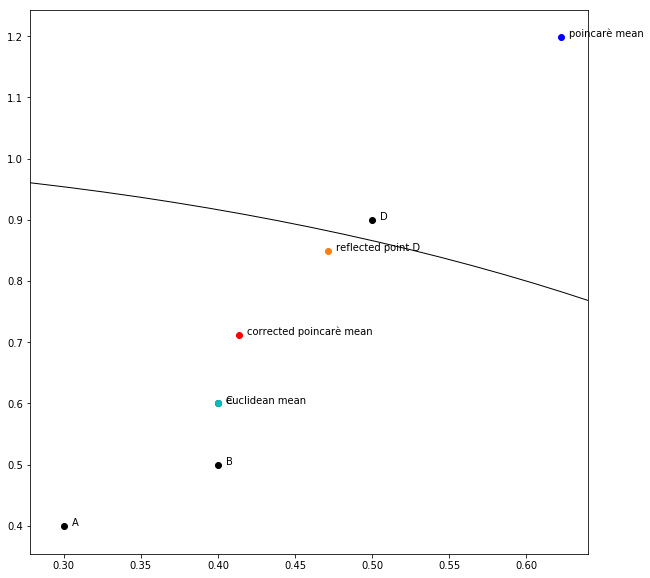

In [105]:
plt.figure(figsize=(10, 10))
for i, ass in enumerate(a):
    plt.scatter(ass[0], ass[1], c = 'k')
    plt.text(ass[0] + 0.005, ass[1], name[i])
    if norm(np.array([ass[0], ass[1]])) >= 1:
        r = inverse_projection(-hyperboloid_projection(np.array([ass[0], ass[1]]), r=1), r = 1)
        plt.scatter(r[0], r[1], c='tab:orange')
        plt.text(r[0]+0.005, r[1], 'reflected point {}'.format(name[i]))

    
plt.scatter(m[0], m[1], c='b')
plt.text(m[0]+0.005, m[1], 'poincarè mean')
plt.scatter(e[0], e[1], c='c')
plt.text(e[0]+0.005, e[1], 'euclidean mean')
plt.scatter(m2[0], m2[1], c='r')
plt.text(m2[0]+0.005, m2[1], 'corrected poincarè mean')
plt.gca().add_artist(plt.Circle((0,0), 1, fill = False))
plt.show()

In [251]:
hyper_distance(a, midpoint([a, b]))

0.33568149263906805

In [252]:
hyper_distance(b, midpoint([a, b]))

0.33568149263906805

In [107]:
def get_parenthood(classes):
    parenthood = {}
    
    for clas in classes:
        
        parenthood[clas] = {}
        
        sparql = SPARQLWrapper("http://dbpedia.org/sparql")
        sparql.setQuery("""
        PREFIX rdf:<http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX vrank:<http://purl.org/voc/vrank#>
        PREFIX dbo:<http://dbpedia.org/ontology/>
            SELECT distinct ?s
            FROM <http://dbpedia.org> 
            FROM <http://people.aifb.kit.edu/ath/#DBpedia_PageRank> 
            WHERE { ?s rdfs:subClassOf dbo:""" + clas + """.
                   }
        """)

        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()

        collector = []

        for result in results["results"]["bindings"]:
            data_a = result["s"]["value"].replace("http://dbpedia.org/ontology/", "")
            if 'http://www.w3.org/2002/07/owl#Thing' not in data_a:
                collector.append((data_a))
        
        parenthood[clas]['sons'] = collector
        
        parenthood[clas]['ancestors'] = []
        ancestor_flag = True
        q = [clas]
        i = 0
        while i<len(q):
            node = q[i]
            sparql.setQuery("""
            PREFIX rdf:<http://www.w3.org/1999/02/22-rdf-syntax-ns#>
            PREFIX vrank:<http://purl.org/voc/vrank#>
            PREFIX dbo:<http://dbpedia.org/ontology/>
                SELECT distinct ?s
                FROM <http://dbpedia.org> 
                FROM <http://people.aifb.kit.edu/ath/#DBpedia_PageRank> 
                WHERE { dbo:""" + node + """ rdfs:subClassOf ?s.
                       }
            """)

            sparql.setReturnFormat(JSON)
            results = sparql.query().convert()

            collector = []

            for result in results["results"]["bindings"]:
                data_a = result["s"]["value"].replace("http://dbpedia.org/ontology/", "")
                data_a = data_a.replace("http://schema.org/", "")
                if 'http://www.w3.org/2002/07/owl#Thing' not in data_a:
                    collector.append((data_a))
                    if data_a not in q:
                        q.append(data_a)
                else:
                    ancestor_flag = False
            
            parenthood[clas]['ancestors'].extend(collector)
            parenthood[clas]['ancestors'] = list(set(parenthood[clas]['ancestors']))
            i += 1
        
        
        sparql.setQuery("""
        PREFIX rdf:<http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX vrank:<http://purl.org/voc/vrank#>
        PREFIX dbo:<http://dbpedia.org/ontology/>
            SELECT distinct ?v ?s
            FROM <http://dbpedia.org> 
            FROM <http://people.aifb.kit.edu/ath/#DBpedia_PageRank> 
            WHERE { dbo:""" + clas + """ rdfs:subClassOf ?s.
                    ?v rdfs:subClassOf ?s.
                   }
        """)

        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()

        collector = []

        for result in results["results"]["bindings"]:
            data_a = result["v"]["value"].replace("http://dbpedia.org/ontology/", "")
            data_b = result["s"]["value"].replace("http://dbpedia.org/ontology/", "")
            if 'http://www.w3.org/2002/07/owl#Thing' not in data_b:
                collector.append((data_a))
        parenthood[clas]['siblings'] = [c for c in collector if c != clas]        
        
    return parenthood

In [9]:
def double_plot(mo_mixed_model, testset, iteration, frac, classes, parenthood):
    
    embeddings = {'t2v': type_embedding, 'hyper': hyperbolic_embedding}
    mo_y_predict = mo_mixed_model.predict(testset[:frac])
#     mo_y_predict[1] = xscaler.inverse_transform(mo_y_predict[1])
    res = check_prediction(labels=Y_test[:frac], 
                       vectors=mo_y_predict,
                       embedding=[embeddings['t2v'], embeddings['hyper']],
                       topn='all',
                       parenthood=parenthood,
                       mode='both')
    
    plt.figure(figsize=(40, 40))
    pred = res['hypLabel']
    plt.subplot(221)
    cnf_matrix = confusion_matrix(y_true = Y_test[:frac], y_pred = pred)
    plot_confusion_matrix(cnf_matrix, classes = classes, title='Hyperbolic middle out {}'.format(iteration))
    
    acc = accuracy_score(y_true=Y_test[:frac], y_pred=pred)
    prec = precision_score(y_true=Y_test[:frac], y_pred=pred, average='weighted')
    rec = recall_score(y_true=Y_test[:frac], y_pred=pred, average='weighted')
    f1 = f1_score(y_true=Y_test[:frac], y_pred=pred, average='weighted')

    print('Accuracy:{} Precision:{} Recall:{} F1:{}'.format(round(acc, 3),
                                                            round(prec, 3), 
                                                            round(rec, 3), 
                                                            round(f1, 3)))

    plt.subplot(222)
    error_matrix(n_class = len(classes), dic=res['hypErr'], classes=classes)

    plt.subplot(223)
    pred = res['t2vLabel']
    cnf_matrix = confusion_matrix(y_true = Y_test[:frac], y_pred = pred)
    plot_confusion_matrix(cnf_matrix, classes = classes, title='t2v middle out {}'.format(iteration))

    acc = accuracy_score(y_true=Y_test[:frac], y_pred=pred)
    prec = precision_score(y_true=Y_test[:frac], y_pred=pred, average='weighted')
    rec = recall_score(y_true=Y_test[:frac], y_pred=pred, average='weighted')
    f1 = f1_score(y_true=Y_test[:frac], y_pred=pred, average='weighted')

    print('Accuracy:{} Precision:{} Recall:{} F1:{}'.format(round(acc, 3),
                                                            round(prec, 3), 
                                                            round(rec, 3), 
                                                            round(f1, 3)))


    
    plt.subplot(224)
    error_matrix(n_class = len(classes), dic=res['t2vErr'], classes=classes)


In [10]:
def find_neighbours(vector, model, mode, tensors, topn):
    node_distances = []
    if mode=='hyper':
#         t = time.time()        
        d = cdist([vector], tensors, hyper_distance)
#         d = pairwise_distances(X = [vector], Y = tensors, metric=hyper_distance, n_jobs=10)
        
#         print('pairwise: {}'.format(time.time() - t))
        
        node_distances = [(label, distance) for label, distance in zip(model.keys(), d[0])]
        if np.isnan(node_distances[0][1]):
            print('norm: {}'.format(norm(vector)))
            
#         t = time.time()
        sorted_list = sorted(node_distances, key=itemgetter(1))
#         print('sort: {}'.format(time.time() - t))      
    elif mode=='t2v':
        sorted_list = model.similar_by_vector(vector, topn=topn, restrict_vocab=None)
    similarities = [x[1] for x in sorted_list]
    labels = [x[0] for x in sorted_list]
    if topn == 'all':
        return similarities, labels
    else:
        return similarities[:topn], labels[:topn]

In [11]:
def check_prediction(labels, vectors, embedding, mode, parenthood, topn, tensors = 0):
    if mode == 'both':
        tensors = [v for v in embedding[1].values()]
        lab2, err2 = check_prediction(labels, vectors[0], embedding[0], 't2v', parenthood, topn)
        lab1, err1 = check_prediction(labels, vectors[1], embedding[1], 'hyper', parenthood, topn, tensors)
        return {'hypLabel' : lab1, 't2vLabel' : lab2, 'hypErr': err1, 't2vErr': err2}
    else:
        if topn == 'all' and mode == 'hyper':
            topn = 751
        elif topn == 'all' and mode == 't2v':
            topn = 403
        correct = 0
        all_labels = list(set(labels))
        
        
        predicted_labels = ['a' for a in labels]
        
        pred_errors = {label: [] for label in all_labels}
        nan_counter = 0
        
        tot = len(labels)
        prec = 0
        
        for i, (label, vector) in enumerate(zip(labels, vectors)):
            sim, neigh = find_neighbours(vector=vector, 
                                               model=embedding, 
                                               mode=mode,
                                               tensors=tensors,
                                               topn=topn)
            if not np.isnan(sim[0]): 
                try:
    #                 if i < 15:
                    pos = np.min(np.where(np.isin(neigh, all_labels)))
                    predicted_labels[i] = neigh[pos]
#                     if mode == 'hyper':
    #                     print('----------------------')
    #                     print('neigh: {}'.format(neigh[:10]))
    #                     print('pos: {}'.format(pos))
    #                     print('label: {}, pred_label : {}'.format(label, predicted_labels[i]))
                except:
                    print('unrecognized, i: {}'.format(i))
                    predicted_labels[i] = 'Unrecognized'

    #             print('---------------------------------')
    #             print('label: {}\n ranking: {},\n pred_lab: {}'.format(label, list(zip(neigh, sim))[:10], predicted_labels[i]))

    #           Mi concentro sugli errori
                j = 0
                flag = True
                while flag and j < pos:
                    if neigh[pos] != label: 
                        n = neigh[j]
                        if n in parenthood[label]['ancestors']:
                            pred_errors[label].append('ancestors')
                            flag = False    

                        elif n in parenthood[label]['sons']:
                            pred_errors[label].append('sons')
                            flag = False                    

                        elif n in parenthood[label]['siblings']:
                            pred_errors[label].append('siblings')
                            flag = False
                    j += 1

                if flag and neigh[pos] != label:
                    pred_errors[label].append('errors')
                if flag and neigh[pos] == label:
                    pred_errors[label].append('correct')
            else:
                nan_counter += 1
                
            perc = round(i/tot, 2)
            
            if perc != prec:
                prec = perc
                clear_output()
                print(perc)
        
        print('nan: {}'.format(nan_counter))
        return predicted_labels, pred_errors

In [12]:
def error_matrix(n_class, dic, classes):
    error_matrix_dict = {'correct' : [0 for x in range(n_class)],
                         'sons' : [0 for x in range(n_class)],
                         'ancestors': [0 for x in range(n_class)],
                         'siblings': [0 for x in range(n_class)],
                         'errors': [0 for x in range(n_class)]}

    for i, clas in enumerate(classes):
        counter = Counter(dic[clas])
        for k in error_matrix_dict.keys():
    #         print(k)
            error_matrix_dict[k][i] = round(counter[k] / sum(counter.values()), 2)

    error_pd = pd.DataFrame(data=error_matrix_dict)

    sns.heatmap(error_pd, annot=True, cmap="YlGnBu", yticklabels=classes)

In [13]:
def import_stanford_hyperbolic(PATH):
    dic = load_data_with_pickle('./dic')
    inv_dic = load_data_with_pickle('./inv_dic')
    with open(PATH, 'r') as inp:
        lines = inp.readlines()
        lines = lines[1:]
        lines = [l.replace('\n','') for l in lines]
        tau = float(lines[0].split(',')[-1])
        stanford_emb = {inv_dic[l.split(',')[0]]: np.array(l.split(',')[1:-1]).astype('float64') for l in lines}
    return stanford_emb, tau

In [14]:
# PATH
# WORD_EMBEDDING_PATH = "./datasets/elmo160k.pkl"
HYPERBOLIC_EMBEDDING_PATH = "/datahdd/vmanuel/hyperbolic_embedding_algorithms/HyperE-Stanford/hyperbolics/dbpedia.r2.emb"
TYPE_EMBEDDING_PATH = "/datahdd/vmanuel/datasets/t2v.bin"

In [15]:
# word_embedding = load_data_with_pickle(WORD_EMBEDDING_PATH)
# hyperbolic_embedding = torch.load(HYPERBOLIC_EMBEDDING_PATH)
hyperbolic_embedding = import_stanford_hyperbolic(HYPERBOLIC_EMBEDDING_PATH)[0]
type_embedding = Word2Vec.load(TYPE_EMBEDDING_PATH)

### import datas without mammals siblings, from layer 1 of ELMo 

In [943]:
# X_train = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/16_classes/X_train')
# Y_train = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/16_classes/Y_train')
# word_train = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/16_classes/word_train')
# X_test = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/16_classes/X_test')
# Y_test = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/16_classes/Y_test')
# word_test = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/16_classes/word_test')
# X_val = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/16_classes/X_val')
# Y_val = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/16_classes/Y_val')
# word_val = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/16_classes/word_val')

In [16]:
X_train = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/15_classes/X_train')
Y_train = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/15_classes/Y_train')
word_train = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/15_classes/word_train')
X_test = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/15_classes/X_test')
Y_test = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/15_classes/Y_test')
word_test = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/15_classes/word_test')
X_val = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/15_classes/X_val')
Y_val = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/15_classes/Y_val')
word_val = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_1/15_classes/word_val')

### import datas with mammals siblings, from layer 2 of ELMo 

In [18]:
# X_train = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_2/80k_full/X_train')
# Y_train = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_2/80k_full/Y_train')
# word_train = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_2/80k_full/word_train')
# X_test = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_2/80k_full/X_test')
# Y_test = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_2/80k_full/Y_test')
# word_test = load_data_with_pickle('/datahdd/vmanuel/datasets/elmo_layer_2/80k_full/word_test')

In [17]:
len(X_test) + len(X_train) + len(X_val)

157170

In [18]:
from collections import Counter
Tr = Counter(Y_train).most_common()
Te = Counter(Y_test).most_common()
Va = Counter(Y_val).most_common()

print('{:^30}|{:^30}|{:^30}'.format('Train','Val', 'Test'))
print('{:-^30}|{:-^30}|{:-^30}'.format('', '', ''))

for x, y, z in zip(Tr, Te, Va):
    print('{:^25}{:^5}|{:^25}{:^5}|{:^25}{:^5}'.format(x[0], x[1], y[0], y[1], z[0], z[1]))

            Train             |             Val              |             Test             
------------------------------|------------------------------|------------------------------
         Company         39026|        Language         4147 |          Award          2709 
        Language         20319|         Company         2913 |         Planet          1976 
          Plant          15395|          Plant          1664 |         Company         1507 
         Mammal          9555 | ArchitecturalStructure  1177 |          Plant          1419 
         Colour          8872 |         Mammal           975 |   FictionalCharacter    1297 
   FictionalCharacter    7841 |   FictionalCharacter     760 |         Mammal          1007 
       EthnicGroup       7556 |       EthnicGroup        446 |        Language          999 
 ArchitecturalStructure  5736 |          Sport           438 |          Sport           640 
          Sport          4787 |         Colour           324 | Archite

## Hyperbolic Normalization

In [232]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# scaler.fit(list(hyperbolic_embedding.values()))

# scaled_hyperbolic_embedding = {k: scaler.transform([v]) for k, v in zip(hyperbolic_embedding.keys(),hyperbolic_embedding.values())}

## Balance Labels

In [ ]:
n = 900

i = 0
flag = True
count = {y: 0 for y in set(Y_test)}

new_x = []
new_y = []

while flag:
    if count[Y_train[i]] < n:
        new_x.append(X_train[i])
        new_y.append(Y_train[i])
        count[Y_train[i]] += 1
    if not min(count.values()) < 900:
        flag = False
    i += 1
    clear_output()
    print(i)

In [163]:
count

{'Insect': 900,
 'Company': 900,
 'AnatomicalStructure': 900,
 'Mammal': 900,
 'Award': 900,
 'Planet': 900,
 'SportsTeam': 900,
 'ArchitecturalStructure': 900,
 'FictionalCharacter': 900,
 'Weapon': 900,
 'Sport': 900,
 'Plant': 900,
 'Language': 900,
 'Bird': 900,
 'EthnicGroup': 900,
 'Colour': 900}

In [172]:
Y_train = np.array(new_y)
X_train = np.array(new_x)

In [173]:
X_train

array([[-0.06575282, -0.25496262,  0.01513287, ..., -0.6071176 ,
         0.16419137,  0.5335511 ],
       [ 0.32937092, -0.02799109,  0.13190134, ...,  0.757948  ,
         0.5785322 , -0.32900742],
       [ 0.04183321,  0.52409136,  0.07574019, ...,  0.10675424,
         0.5515907 , -0.035191  ],
       ...,
       [ 0.02851999, -0.7188842 ,  0.37164798, ...,  0.16882053,
         0.85022223, -0.0135975 ],
       [ 0.33396772, -0.27885526,  0.38496667, ...,  0.5804769 ,
         0.23694843,  0.09796649],
       [ 0.40863127, -0.35523832,  0.2674905 , ...,  0.14959757,
         0.11210977,  0.3544057 ]], dtype=float32)

In [500]:
list(zip(Counter(Y_val), Counter(Y_val).values(), Counter(Y_val[:10000]),Counter(Y_val[:10000]).values()))

[('Mammal', 1565, 'Mammal', 1365),
 ('Plant', 1685, 'Plant', 1454),
 ('Sport', 1486, 'Sport', 1288),
 ('Language', 1523, 'Language', 1325),
 ('Award', 318, 'Award', 291),
 ('EthnicGroup', 784, 'EthnicGroup', 697),
 ('Company', 1598, 'Company', 1393),
 ('Bird', 85, 'Bird', 79),
 ('Artist', 316, 'Artist', 282),
 ('ArchitecturalStructure', 557, 'ArchitecturalStructure', 482),
 ('FictionalCharacter', 797, 'FictionalCharacter', 687),
 ('Scientist', 199, 'Scientist', 175),
 ('Planet', 122, 'Planet', 106),
 ('SportsTeam', 136, 'SportsTeam', 117),
 ('Weapon', 155, 'Weapon', 136),
 ('Insect', 110, 'Insect', 93),
 ('Colour', 33, 'Colour', 30)]

### Dataset Creation

In [19]:
y_t2v_train = []
y_t2v_test = []
y_hyp_train = []
y_hyp_test = []
y_t2v_val = []
y_hyp_val = []
not_present = []

for label in Y_train:
    try:
        y_t2v_train.append(type_embedding.wv[label])
        y_hyp_train.append(hyperbolic_embedding[label])
#     y_hyp_train.append(scaled_hyperbolic_embedding[label][0])
    except:
        if label not in not_present:
            not_present.append(label)

            
for label in Y_val:
    try:
        y_t2v_val.append(type_embedding.wv[label])
        y_hyp_val.append(hyperbolic_embedding[label])
    except:
        if label not in not_present:
            not_present.append(label)

for label in Y_test:
    try:
        y_t2v_test.append(type_embedding.wv[label])
        y_hyp_test.append(hyperbolic_embedding[label])
#     y_hyp_train.append(scaled_hyperbolic_embedding[label][0])
    except:
        if label not in not_present:
            not_present.append(label)

y_t2v_val = np.array(y_t2v_val)
y_t2v_test = np.array(y_t2v_test)
y_t2v_train = np.array(y_t2v_train)
y_hyp_val = np.array(y_hyp_val)
y_hyp_test = np.array(y_hyp_test)
y_hyp_train = np.array(y_hyp_train)

In [20]:
not_present

[]

## Network

In [276]:
def make_network(input_dimension = 0, mixed_dimension = 100):
    if input_dimension == 0:
        input_dimension = word_embedding.wv.vector_size
    type_embedding_dimension = type_embedding.wv.vector_size
    hyper_embedding_dimension = 2
    
    inp = Input(shape=(input_dimension, ))

    mixed = Dense(int(mixed_dimension * 2), activation = "tanh")(inp)
    droppy = Dropout(rate=0.3)(mixed)
    mixed = Dense(mixed_dimension, activation = "tanh")(droppy)
    droppy = Dropout(rate=0.3)(mixed)
    mixed = Dense(mixed_dimension, activation = "tanh")(droppy)
    droppy = Dropout(rate=0.3)(mixed)
    mixed = Dense(int(mixed_dimension/2), activation = "tanh")(mixed)



#     hyperbolic_embedding_layer = Dense(128, activation='tanh')(mixed)
    hyperbolic_embedding_layer = Dense(hyper_embedding_dimension, name='Hyper')(mixed)

#     type_embedding_layer = Dense(256, activation='tanh')(mixed)
    type_embedding_layer = Dense(type_embedding_dimension, name='T2V')(mixed)
    
#     inp = keras.Input(shape=(input_dimension, ))
#     print(2)
#     hidden = keras.layers.Dense(512, activation='relu')(inp)
#     print(3)
#     hidden = keras.layers.Dense(256, activation='relu')(hidden)
#     print(4)
#     hyperbolic_embedding_layer = keras.layers.Dense(hyper_embedding_dimension)(hidden)
#     print(5)
#     type_embedding_layer = keras.layers.Dense(type_embedding_dimension)(hidden)
    return inp, mixed, hyperbolic_embedding_layer, type_embedding_layer

In [452]:
1 - max([norm(x)**2 for x in y_hyp_train]) > 1e-8

True

In [447]:
1.0201 - max([norm(x)**2 for x in y_hyp_train])

0.020100043524702516

In [448]:
(1.21 - norm(hyperbolic_embedding['Mammal'])**2) ** 2

0.04410002512168258

In [156]:
def loss_w_params(weights_dic, weights_sum):

    def fun(t):
        
        
        return t[1]* weights_dic.get((
            K.eval(t[0][0]), 
            K.eval(t[0][1])), 0)
    
    def hyperbolic_loss(y_true, y_pred):
        num = 2 * tf.norm(y_true - y_pred, axis = 1)**2
        
        n = tf.norm(y_pred, axis = 1)**2
        clipped_norm = tf.minimum([1 - 1e-8], n)
        
        densx = (1 - clipped_norm)
        dendx = (1 - tf.norm(y_true, axis = 1)**2)
        
        densx = tf.clip_by_value(densx,
                                   clip_value_min=1e-7,
                                   clip_value_max=1)
        denom = densx * dendx
        frac = num/denom
        acos = tf.math.acosh(1  + frac)

        weighted_dists = tf.map_fn(fun, (y_true, acos), dtype=(tf.float32))
                
        ret = K.sum(acos)/weights_sum
        
        return ret
    
    return hyperbolic_loss

In [281]:
def hyperbolic_loss(y_true, y_pred):

        num = 2  *  tf.norm(y_true - y_pred, axis = 1)
        n = tf.norm(y_pred, axis = 1)**2
#         clipped_norm = tf.minimum([1.0], n)
        densx = (1 - n)
        dendx = (1 - tf.norm(y_true, axis = 1)**2)
        
        densx = tf.clip_by_value(densx,
                                   clip_value_min=1e-18,
                                   clip_value_max=1)
        dendx = tf.clip_by_value(dendx,
                                   clip_value_min=1e-15,
                                   clip_value_max=1)
        
        denom = densx * dendx

        
        frac = num/denom
        acos = tf.math.acosh(1  + frac)

        intern_circle_distance = n - 0.81
        
        ret = tf.where(tf.logical_and(intern_circle_distance > 0,
                                      intern_circle_distance < 0.19),
                        acos,
                        acos*4)        
        return tf.reduce_mean(ret)
        

In [286]:
def cosine_loss(y_true, y_pred):
    return keras.losses.cosine_proximity(y_true=y_true, y_pred=y_pred) * 10

In [668]:
a = tf.constant([[-1.0, 1.5]])
# b = tf.constant([list(hyperbolic_embedding['Animal'])])

# K.eval(hyperbolic_loss(b, a))
n = a - 1
K.eval(tf.where(tf.logical_and(tf.greater(n, 0),
                               tf.less(n, 2)),
                a, a*2))

# K.eval(tf.reduce_all(a > 0))

array([[-2. ,  1.5]], dtype=float32)

In [46]:
m = min(Counter(Y_train).values())

weights_dic = {}

for k,v in Counter(Y_train).items():
    weights_dic[k] = m/v

s = 0
for k, v in weights_dic.items():
    s += v * Counter(Y_train)[k]

s

15344.0

### Mixed Model

In [287]:
# from keras.optimizers import Adam

inp, mixed, hyperbolic_embedding_layer, type_embedding_layer = make_network(1024, 256)

early_stop = EarlyStopping(monitor='val_loss', patience = 20, restore_best_weights=True)
# opt = Adam(lr = 0.001)

mixed_model = Model(input=inp, output=[type_embedding_layer, hyperbolic_embedding_layer])
mixed_model.compile(optimizer='adam', loss=[cosine_loss, hyperbolic_loss])
mixed_history = mixed_model.fit(X_train
                                , [y_t2v_train, y_hyp_train] 
                                , epochs = 200
                                , batch_size = 512
                                , validation_data = (X_val, [y_t2v_val, y_hyp_val])
                                , shuffle = True
                                , callbacks = [early_stop]
               )

Train on 130136 samples, validate on 13065 samples
Epoch 1/200
130136/130136 [==============================] - 6s 47us/step - loss: 34.9369 - T2V_loss: -7.0722 - Hyper_loss: 42.0091 - val_loss: 35.2600 - val_T2V_loss: -5.7120 - val_Hyper_loss: 40.9720
Epoch 2/200
130136/130136 [==============================] - 4s 34us/step - loss: 28.8235 - T2V_loss: -8.7567 - Hyper_loss: 37.5802 - val_loss: 33.6338 - val_T2V_loss: -6.7621 - val_Hyper_loss: 40.3960
Epoch 3/200
130136/130136 [==============================] - 4s 32us/step - loss: 27.1677 - T2V_loss: -9.0513 - Hyper_loss: 36.2190 - val_loss: 32.1373 - val_T2V_loss: -7.7747 - val_Hyper_loss: 39.9121
Epoch 4/200
130136/130136 [==============================] - 4s 34us/step - loss: 22.6474 - T2V_loss: -9.3122 - Hyper_loss: 31.9597 - val_loss: 28.6961 - val_T2V_loss: -8.2019 - val_Hyper_loss: 36.8980
Epoch 5/200
130136/130136 [==============================] - 4s 33us/step - loss: 26.1848 - T2V_loss: -9.3504 - Hyper_loss: 35.5352 - val_los

In [284]:
pred_test = mixed_model.predict(X_test)[1]
pred_train = mixed_model.predict(X_train)[1]

In [285]:
print('Train: {}'.format(Counter(['outside' if norm(p) > 1 else 'inside' for p in pred_train])))
print('Test: {}'.format(Counter(['outside' if norm(p) > 1 else 'inside' for p in pred_test])))

print('Train mean Norm: {:.4f}'.format(np.mean([norm(p) for p in pred_train])))
print('Test  mean Norm: {:.4f}'.format(np.mean([norm(p) for p in pred_test])))
# print('Train std  Norm: {:.4f}'.format(np.std([norm(p) for p in pred_train])))
# print('Test  std  Norm: {:.4f}'.format(np.std([norm(p) for p in pred_test])))

Train: Counter({'inside': 130018, 'outside': 118})
Test: Counter({'inside': 13968, 'outside': 1})
Train mean Norm: 0.9054
Test  mean Norm: 0.7087


In [ ]:
#  Train test  hyperparameters
# ------------------------------------
## 0.72, 0.65, 1e-8
## 0.74, 0.67, 1e-15 
## 0.79, 0.73, 1e-25 
## 0.84, 0.79, 1e-15  inside 0.8 * 2: 
## 0.83, 0.75, 1e-15  inside 0.9 * 3: 
## 0.83, 0.74, 1e-15  inside 0.9 * 4: 
## 0.82, 0.78, 1e-15  inside 0.9 * 4 bs 1024: 
## 0.88, 0.82, 1e-15  inside 0.9 * 4 bs 512: 
## 0.93, 0.88, 1e-15  inside 0.9 * 4 bs 512, new architecture: 

In [952]:
norms = [norm(p) for p in pred_test]

In [953]:
a = pd.DataFrame(norms)

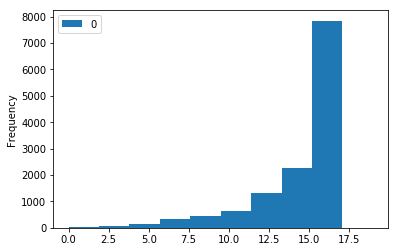

In [954]:
pd.DataFrame(list(pd.cut(norms, 20, retbins=True, labels = [i for i in range(20)])[0])).plot.hist()

In [955]:
len(norms)

13075

In [956]:
print('Train: {}'.format(Counter(['bad' if norm(p) < 0.9 else 'good' for p in pred_train])))
print('Test: {}'.format(Counter(['bad' if norm(p) < 0.9 else 'good' for p in pred_test])))

Train: Counter({'good': 111234, 'bad': 9779})
Test: Counter({'good': 8372, 'bad': 4703})


In [205]:
classes = list(set(Y_train))

In [206]:
parenthood = get_parenthood(classes)

1.0
nan: 0


/home/vmanuel/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vmanuel/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy:0.211 Precision:0.164 Recall:0.211 F1:0.17
Accuracy:0.587 Precision:0.54 Recall:0.587 F1:0.537
radius needed: 1.0


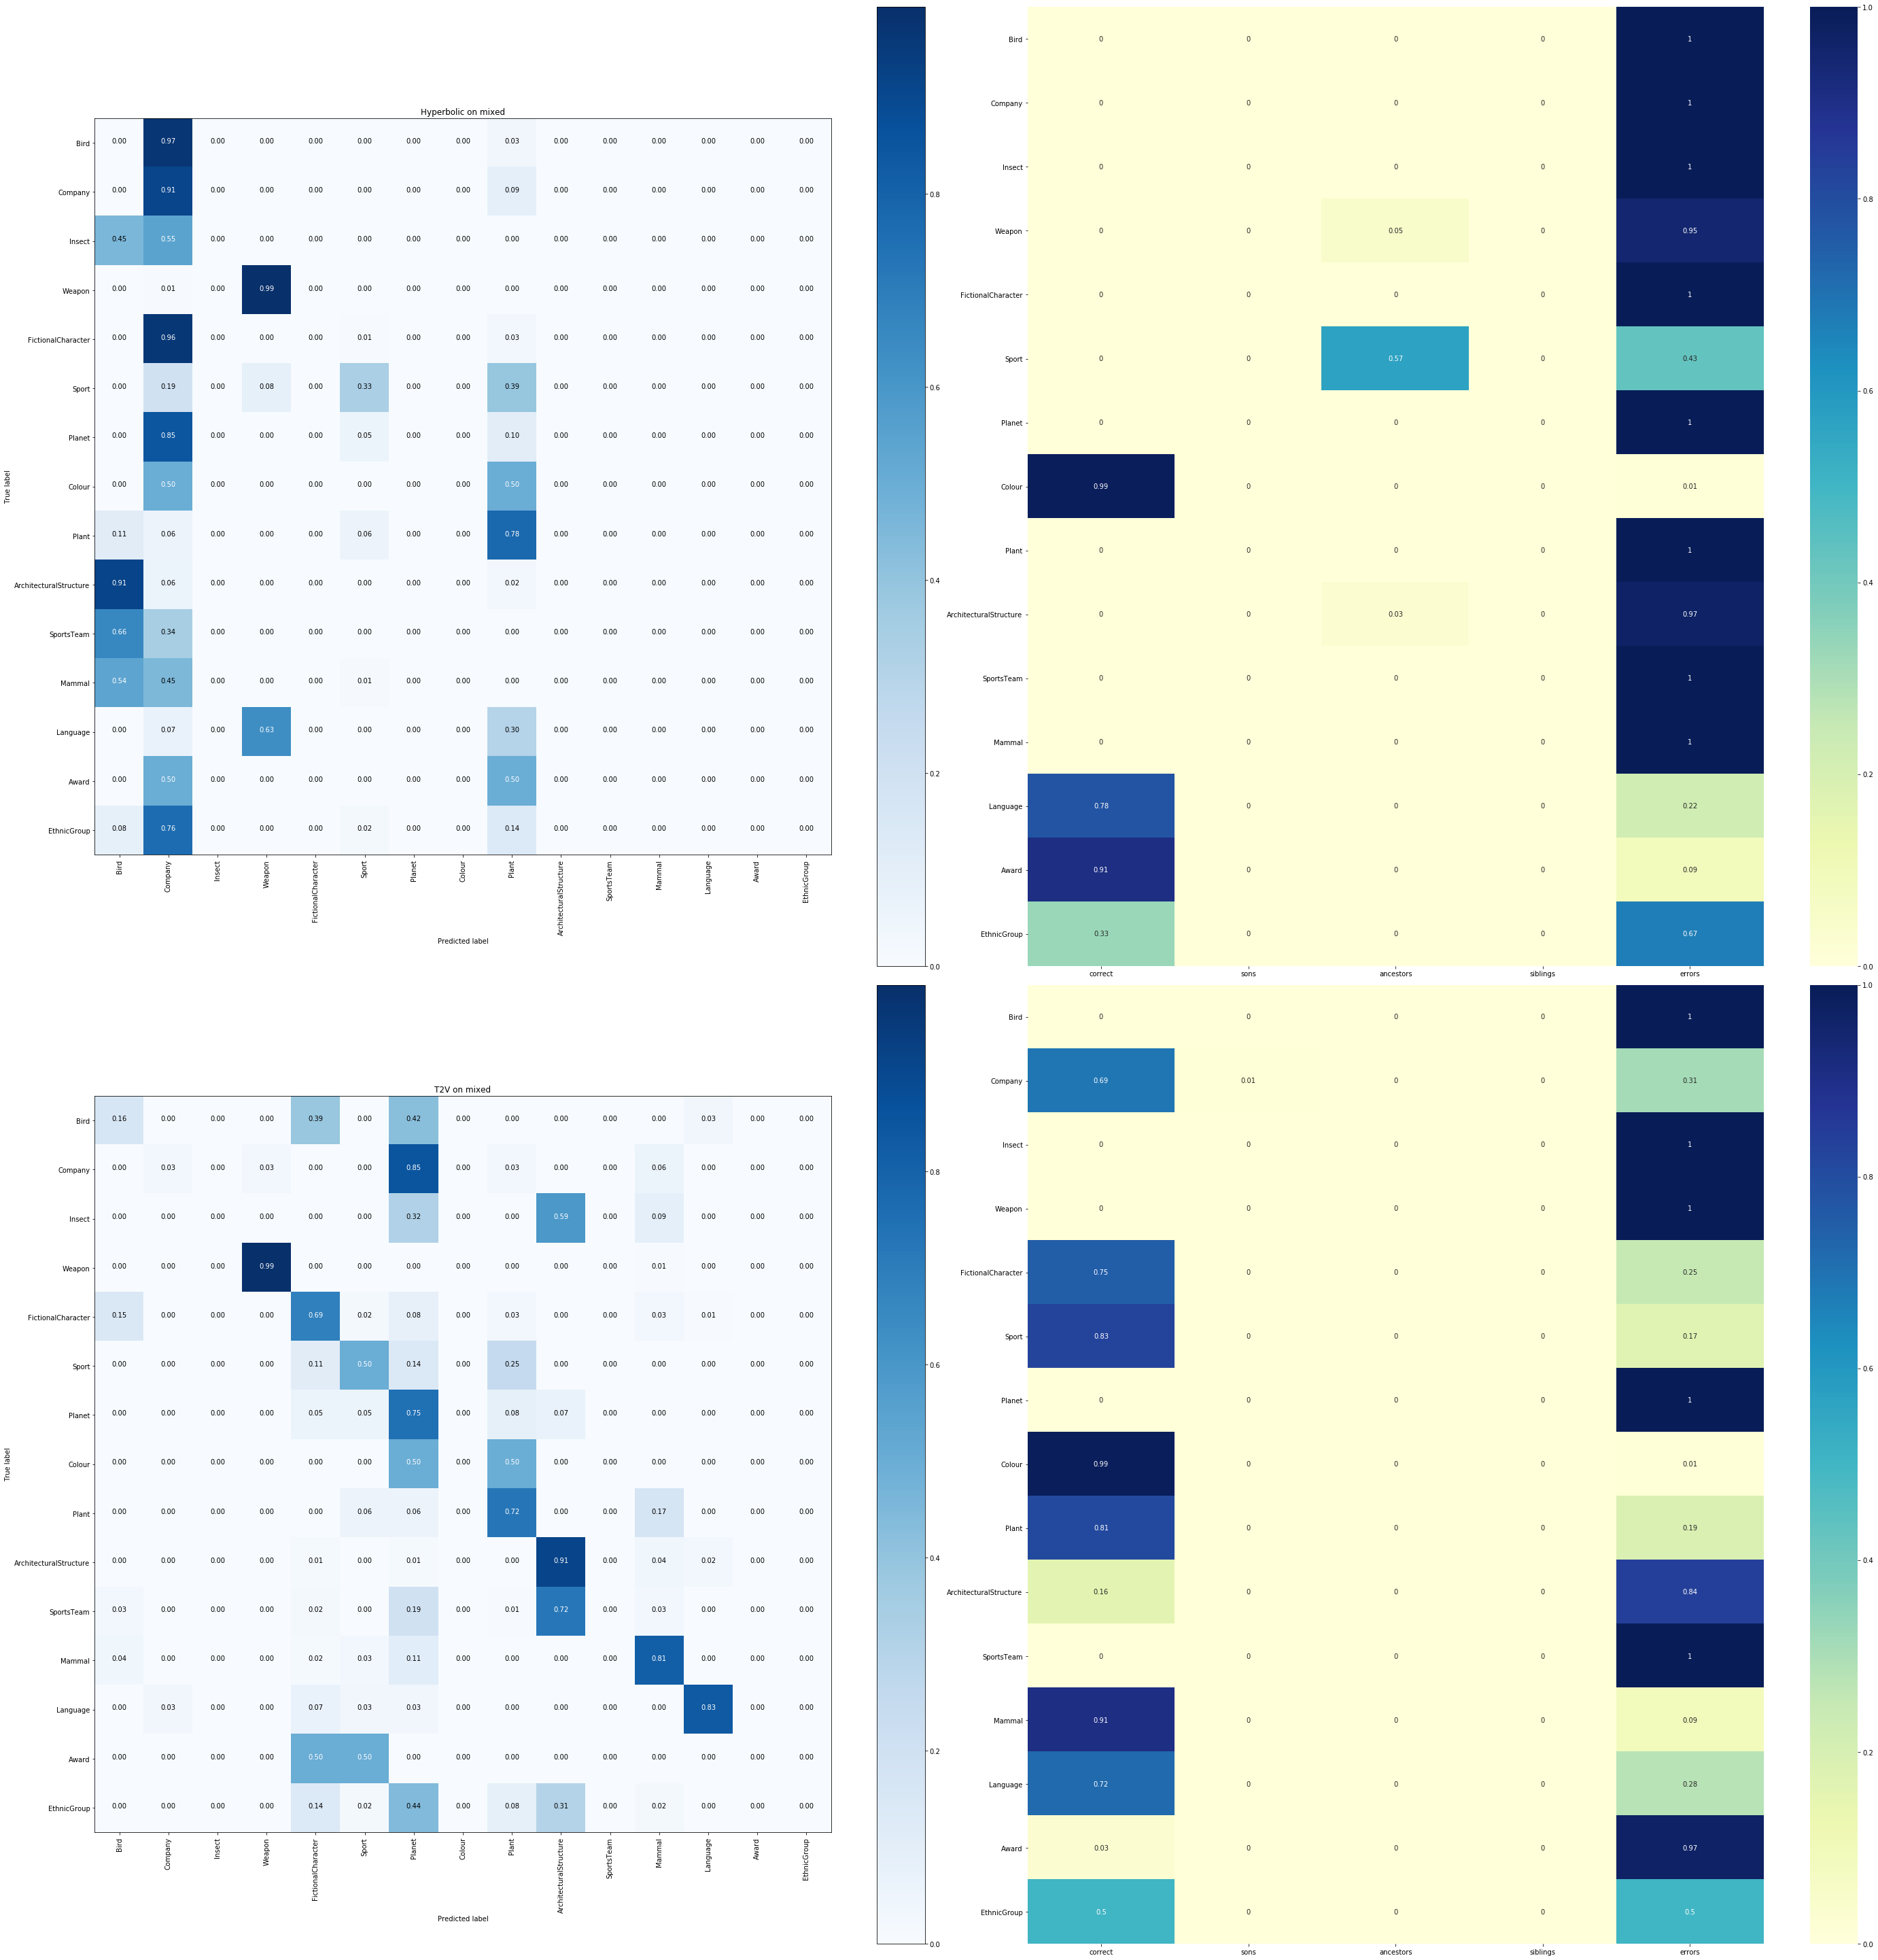

In [207]:

# n = len(X_test)
n = 1000

y_predict = mixed_model.predict(X_test[:n])

# y_predict[1] = xscaler.inverse_transform(y_predict[1])
r = np.floor(max(norm(np.array(y_predict[1]), axis = 1)) * 10)/10 + 0.1

print('radius needed: {}'.format(r))

res = check_prediction(labels=Y_test[:n], 
                   vectors=y_predict,
                   embedding=[type_embedding, hyperbolic_embedding],
                   topn='all',
                   parenthood=parenthood,
                   mode='both')

plt.figure(figsize=(40, 40))

plt.subplot(221)
pred = res['hypLabel']
cnf_matrix = confusion_matrix(y_true = Y_test[:n], y_pred = pred)
plot_confusion_matrix(cnf_matrix, classes = classes, title='Hyperbolic on mixed')

acc = accuracy_score(y_true=Y_test[:n], y_pred=pred)
prec = precision_score(y_true=Y_test[:n], y_pred=pred, average='weighted')
rec = recall_score(y_true=Y_test[:n], y_pred=pred, average='weighted')
f1 = f1_score(y_true=Y_test[:n], y_pred=pred, average='weighted')

n_prec = precision_score(y_true=Y_test[:n], y_pred=pred, average=None)
n_rec = recall_score(y_true=Y_test[:n], y_pred=pred, average=None)
n_f1 = f1_score(y_true=Y_test[:n], y_pred=pred, average=None)


print('Accuracy:{} Precision:{} Recall:{} F1:{}'.format(round(acc, 3),
                                                        round(prec, 3), 
                                                        round(rec, 3), 
                                                        round(f1, 3)))

plt.subplot(222)
error_matrix(n_class = len(classes), dic=res['hypErr'], classes=classes)


plt.subplot(223)
pred = res['t2vLabel']
cnf_matrix = confusion_matrix(y_true = Y_test[:n], y_pred = pred)
plot_confusion_matrix(cnf_matrix, classes = classes, title='T2V on mixed')

acc = accuracy_score(y_true=Y_test[:n], y_pred=pred)
prec = precision_score(y_true=Y_test[:n], y_pred=pred, average='weighted')
rec = recall_score(y_true=Y_test[:n], y_pred=pred, average='weighted')
f1 = f1_score(y_true=Y_test[:n], y_pred=pred, average='weighted')

print('Accuracy:{} Precision:{} Recall:{} F1:{}'.format(round(acc, 3),
                                                        round(prec, 3), 
                                                        round(rec, 3), 
                                                        round(f1, 3)))

plt.subplot(224)
error_matrix(n_class = len(classes), dic=res['t2vErr'], classes=classes)

plt.savefig('./im/16_classes/mixed_performance_2.png', dpi = 100)

print('radius needed: {}'.format(r))


In [ ]:
## 0.35 0.68 2 tanh / 0.43 0.6  3 tanh / 0.49 0.57 3 relu / 3 relu + output dedicated layer

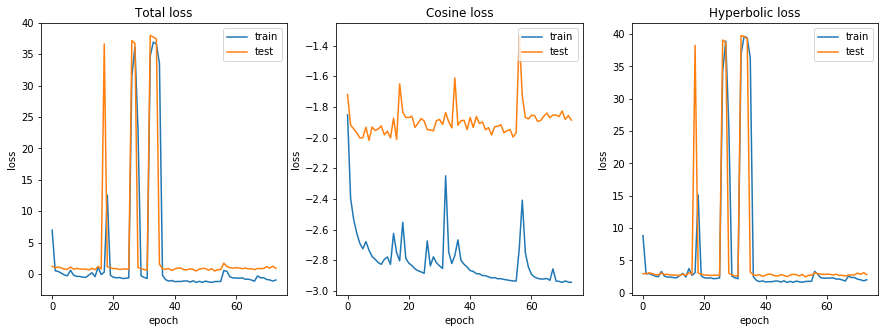

In [71]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(mixed_history.history['loss'])
plt.plot(mixed_history.history['val_loss'])
plt.title('Total loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(132)
plt.plot(mixed_history.history['T2V_loss'])
plt.plot(mixed_history.history['val_T2V_loss'])
plt.title('Cosine loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(133)
plt.plot(mixed_history.history['Hyper_loss'])
plt.plot(mixed_history.history['val_Hyper_loss'])
plt.title('Hyperbolic loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('./im/full/sibling_mixed_losses_1')
plt.show()


## Middle Out Analysis

### make an encoder from mixed network 

In [523]:
inp, mixed, hyperbolic_embedding_layer, type_embedding_layer = make_network(1024, 256)

mixed_encoder = Model(input=inp, output=mixed)
# mixed_encoder.set_weights(mixed_model.get_weights()[0:4])
# mixed_encoder.set_weights(mixed_model.get_weights()[0:6])
mixed_encoder.set_weights(mixed_model.get_weights()[0:10])

In [524]:
encoded_train = mixed_encoder.predict(X_train)
encoded_test = mixed_encoder.predict(X_test)
encoded_val = mixed_encoder.predict(X_val)

### train mixed with encoded input

In [526]:
inp, mixed, hyperbolic_embedding_layer, type_embedding_layer = make_network(input_dimension = 256, mixed_dimension = 64)

early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

mo_mixed_model = Model(input=inp, output=[type_embedding_layer, hyperbolic_embedding_layer])
mo_mixed_model.compile(optimizer='adam', loss=[cosine_loss, hyperbolic_loss])
mo_mixed_history = mo_mixed_model.fit(encoded_train[:10000]
                                      , [y_t2v_train[:10000], y_hyp_train[:10000]]
                                      , epochs = 200
                                      , batch_size = 128
                                      , validation_data = (encoded_val, [y_t2v_val, y_hyp_val])
                                      , shuffle = True
                                , callbacks = [early_stop]
               )

Train on 10000 samples, validate on 11469 samples
Epoch 1/200
10000/10000 [==============================] - 10s 1ms/step - loss: 5.4586 - T2V_loss: -5.3535 - Hyper_loss: 10.8122 - val_loss: 4.3600 - val_T2V_loss: -6.1255 - val_Hyper_loss: 10.4855
Epoch 2/200
10000/10000 [==============================] - 1s 101us/step - loss: 2.3403 - T2V_loss: -7.8062 - Hyper_loss: 10.1465 - val_loss: 3.6333 - val_T2V_loss: -6.8802 - val_Hyper_loss: 10.5135
Epoch 3/200
10000/10000 [==============================] - 1s 102us/step - loss: 1.4038 - T2V_loss: -8.6106 - Hyper_loss: 10.0144 - val_loss: 3.1680 - val_T2V_loss: -7.2844 - val_Hyper_loss: 10.4524
Epoch 4/200
10000/10000 [==============================] - 1s 107us/step - loss: 0.9407 - T2V_loss: -9.0061 - Hyper_loss: 9.9468 - val_loss: 2.9666 - val_T2V_loss: -7.4924 - val_Hyper_loss: 10.4590
Epoch 5/200
10000/10000 [==============================] - 1s 111us/step - loss: 0.6627 - T2V_loss: -9.2383 - Hyper_loss: 9.9010 - val_loss: 2.7490 - val_T2

In [235]:
encoded_train_vector_types_dict = {k: [] for k in classes}
for vec, clas in zip(encoded_train, Y_train):
    encoded_train_vector_types_dict[clas].append(vec)

In [ ]:
### 0.381, 0.631

1.0
nan: 0


/home/vmanuel/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vmanuel/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy:0.244 Precision:0.203 Recall:0.244 F1:0.212
Accuracy:0.572 Precision:0.425 Recall:0.572 F1:0.484


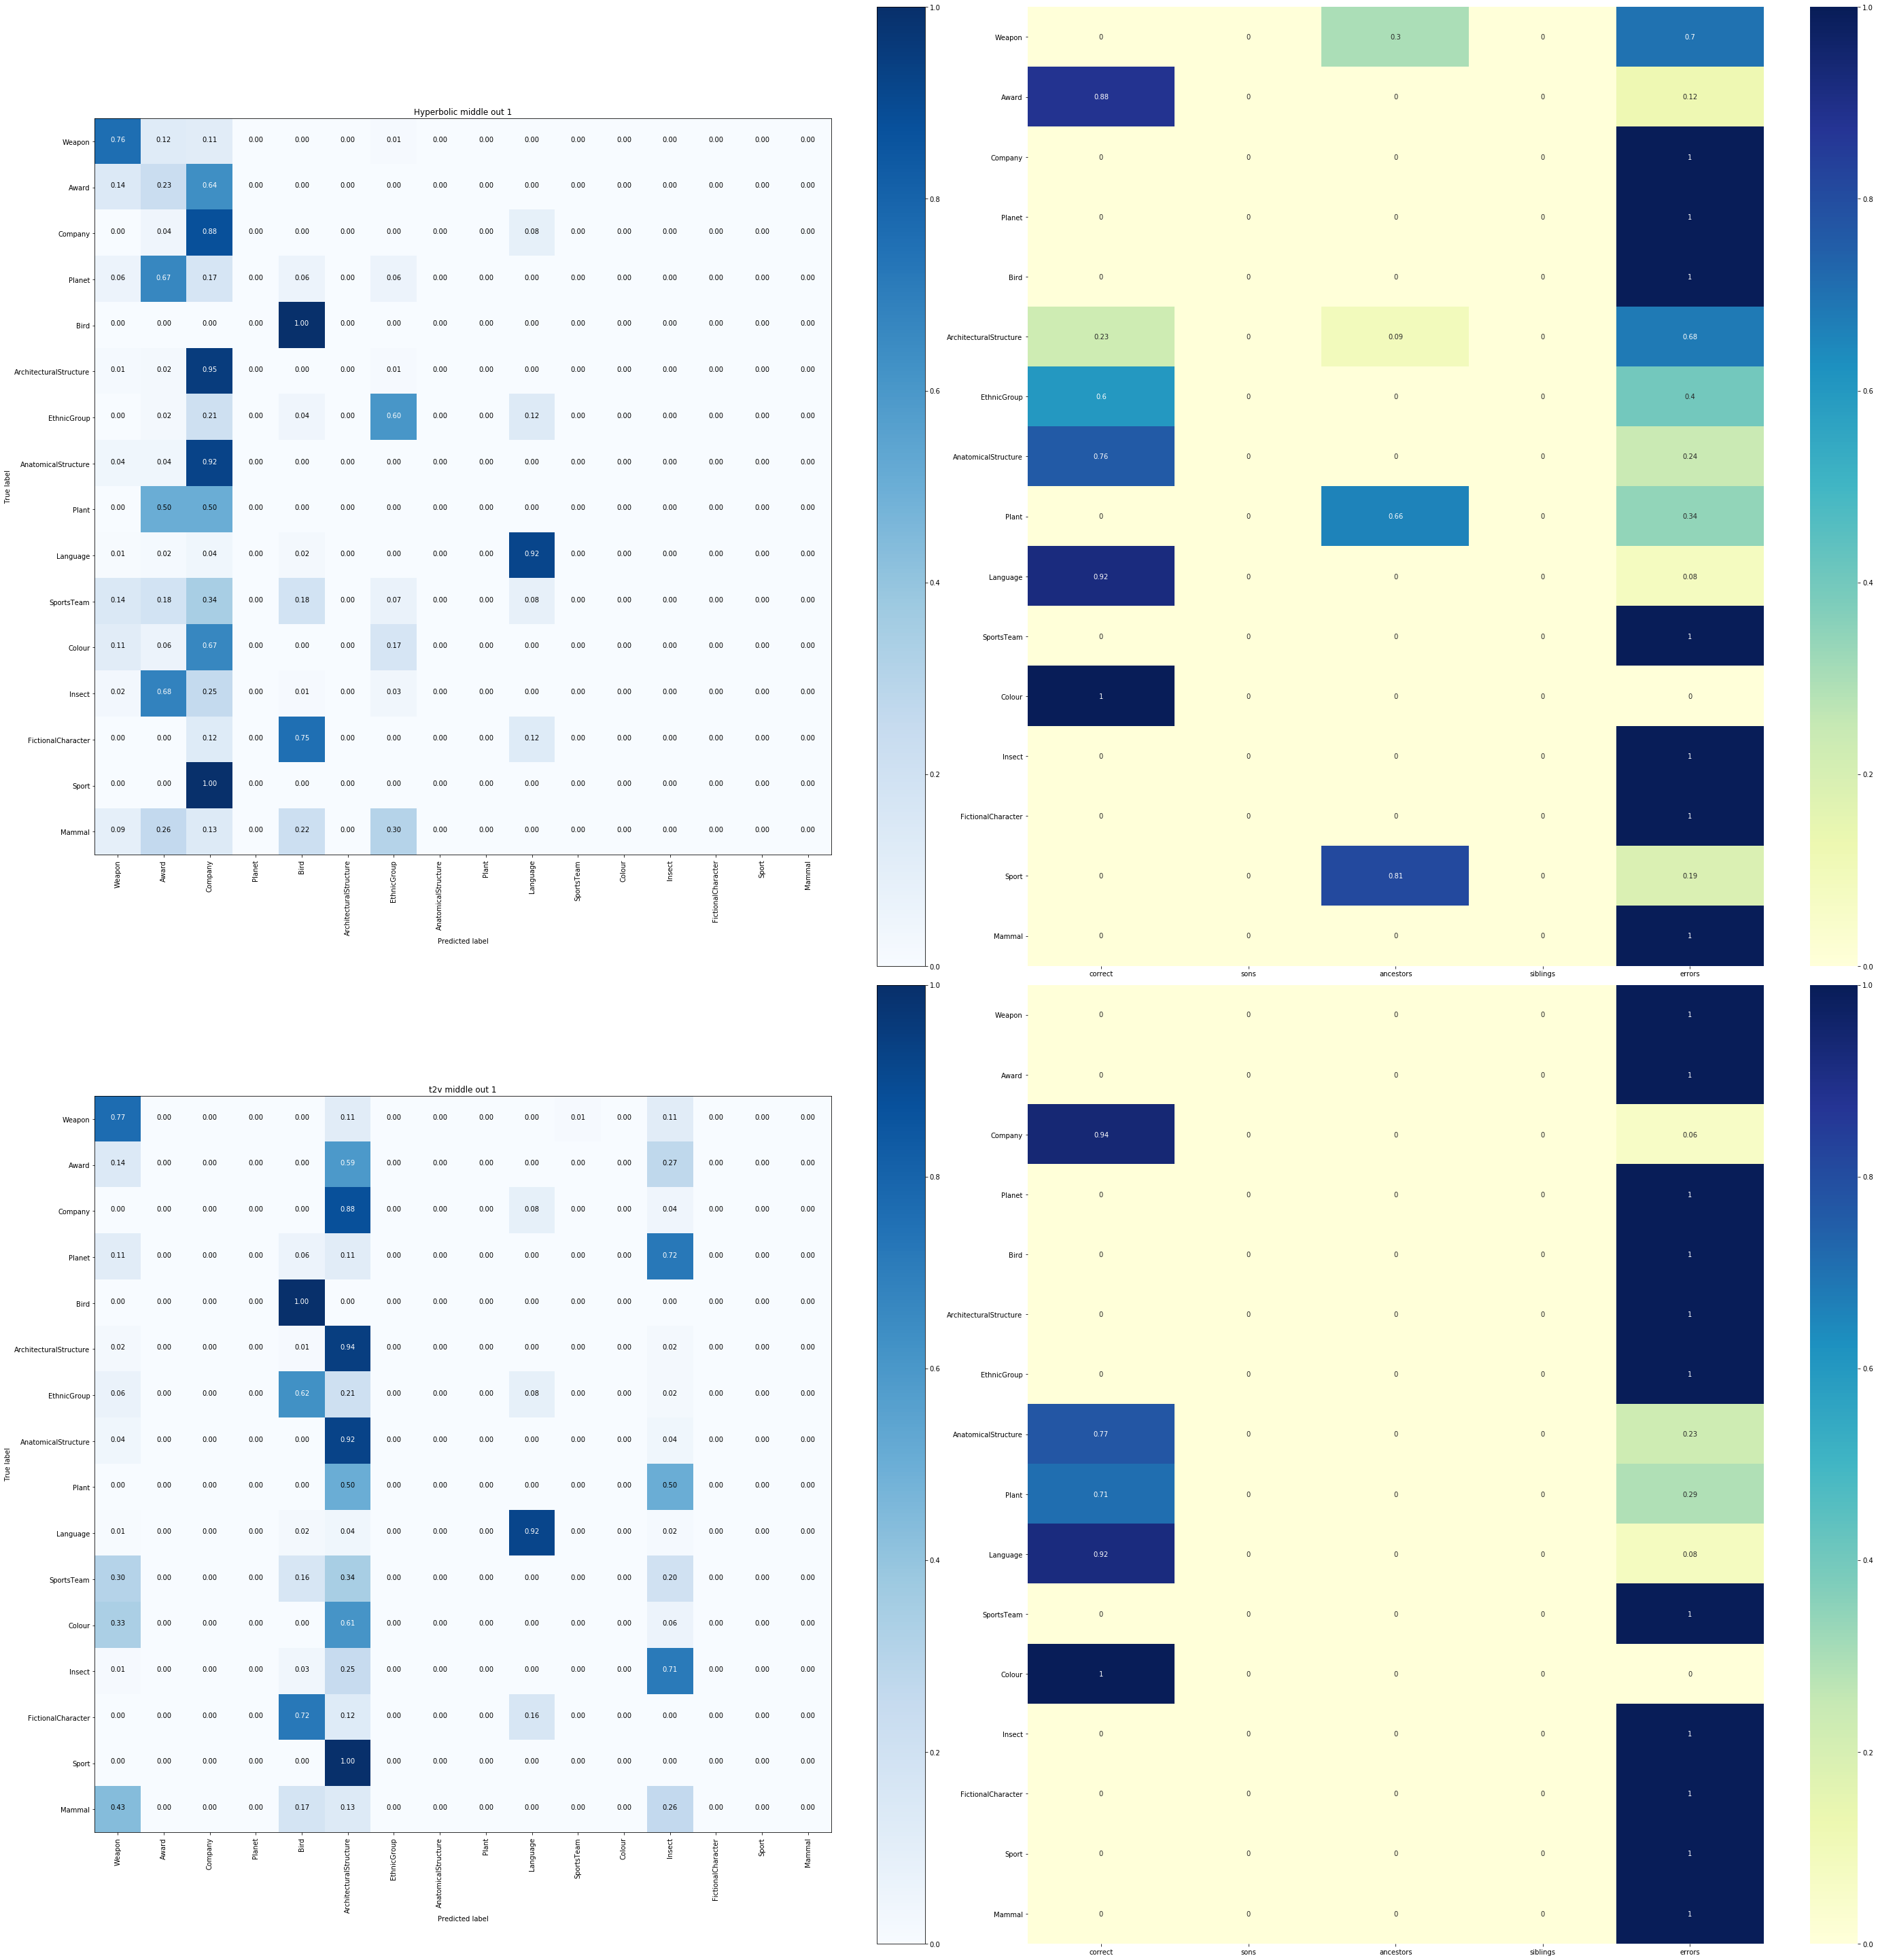

In [236]:
double_plot(mo_mixed_model, encoded_test, 1, 1000, classes, parenthood)
plt.savefig('./im/16_classes/middle-out_performance_1.png', dpi = 100)

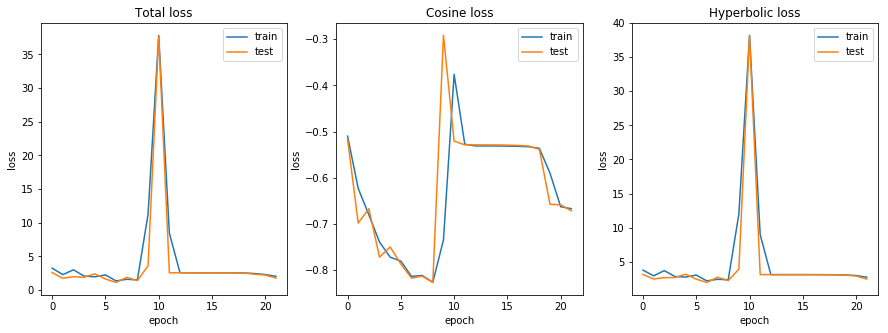

In [237]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(mo_mixed_history.history['loss'])
plt.plot(mo_mixed_history.history['val_loss'])
plt.title('Total loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(132)
plt.plot(mo_mixed_history.history['T2V_loss'])
plt.plot(mo_mixed_history.history['val_T2V_loss'])
plt.title('Cosine loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(133)
plt.plot(mo_mixed_history.history['Hyper_loss'])
plt.plot(mo_mixed_history.history['val_Hyper_loss'])
plt.title('Hyperbolic loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('./im/full/middle_out_losses_1')
plt.show()


In [67]:
!mkdir /datahdd/vmanuel/datasets/models/datas/16_classes

In [120]:
mixed_model.save_weights('/datahdd/vmanuel/datasets/models/datas/16_classes/mixed_model_weights')
# mo_mixed_model.save_weights('/datahdd/vmanuel/datasets/models/datas/16_classes/mo_mixed_model')

## Double Middle Out

In [127]:
inp, mixed, hyperbolic_embedding_layer, type_embedding_layer = make_network(input_dimension=200, mixed_dimension=100)

mo_mixed_encoder = Model(input=inp, output=mixed)

# mo_mixed_encoder.set_weights(mo_mixed_model.get_weights()[0:4])
mo_mixed_encoder.set_weights(mo_mixed_model.get_weights()[0:6])
# mo_mixed_encoder.set_weights(mo_mixed_model.get_weights()[0:10])

In [128]:
double_encoded_train = mo_mixed_encoder.predict(encoded_train)
double_encoded_test = mo_mixed_encoder.predict(encoded_test)

In [223]:
inp, mixed, hyperbolic_embedding_layer, type_embedding_layer = make_network(input_dimension = 256, mixed_dimension = 64)

early_stop = EarlyStopping(monitor='val_loss', patience = 20, restore_best_weights=True)

double_mo_mixed_model = Model(input=inp, output=[type_embedding_layer, hyperbolic_embedding_layer])
double_mo_mixed_model.compile(optimizer='adam', loss=['cosine_proximity', hyperbolic_loss])
double_mo_mixed_history = double_mo_mixed_model.fit(double_encoded_train
                                                    , [y_t2v_train, y_hyp_train]
                                                    , epochs = 200
                                                    , batch_size = 1024
                                                    , validation_split=0.2
                                                    , shuffle = True
                                                    , callbacks = [early_stop]
               )

NameError: name 'double_encoded_train' is not defined

In [35]:
double_plot(double_mo_mixed_model, double_encoded_test, 2, len(X_test), classes, parenthood)
plt.savefig('./im/double_middle_out_performance_2.png')

NameError: name 'double_mo_mixed_model' is not defined

## Triple Middle Out

In [133]:
inp, mixed, hyperbolic_embedding_layer, type_embedding_layer = make_network(input_dimension=100, mixed_dimension=50)

bi_mo_mixed_encoder = Model(input=inp, output=mixed)

# bi_mo_mixed_encoder.set_weights(double_mo_mixed_model.get_weights()[0:4])
bi_mo_mixed_encoder.set_weights(double_mo_mixed_model.get_weights()[0:6])
# mo_mixed_encoder.set_weights(mo_mixed_model.get_weights()[0:10])

In [134]:
tri_encoded_train = bi_mo_mixed_encoder.predict(double_encoded_train)
tri_encoded_test = bi_mo_mixed_encoder.predict(double_encoded_test)

In [135]:
inp, mixed, hyperbolic_embedding_layer, type_embedding_layer = make_network(input_dimension = 50, mixed_dimension = 30)

early_stop = EarlyStopping(monitor='val_loss', patience = 20, restore_best_weights = True)

tri_mo_mixed_model = Model(input=inp, output=[type_embedding_layer, hyperbolic_embedding_layer])
tri_mo_mixed_model.compile(optimizer='adam', loss=['cosine_proximity', hyperbolic_loss])
tri_mo_mixed_history = tri_mo_mixed_model.fit(tri_encoded_train
                                      , [y_t2v_train, y_hyp_train]
                                      , epochs = 200
                                      , batch_size = 1024
                                      , validation_split=0.2
                                      , shuffle = True
                                , callbacks = [early_stop]
               )

Train on 159504 samples, validate on 39876 samples
Epoch 1/200
159504/159504 [==============================] - 2s 13us/step - loss: -0.3219 - T2V_loss: -0.7143 - Hyper_loss: 0.3924 - val_loss: -0.6602 - val_T2V_loss: -0.9369 - val_Hyper_loss: 0.2767
Epoch 2/200
159504/159504 [==============================] - 1s 7us/step - loss: -0.7305 - T2V_loss: -0.9612 - Hyper_loss: 0.2307 - val_loss: -0.7904 - val_T2V_loss: -0.9633 - val_Hyper_loss: 0.1730
Epoch 3/200
159504/159504 [==============================] - 1s 7us/step - loss: -0.7755 - T2V_loss: -0.9716 - Hyper_loss: 0.1961 - val_loss: -0.7532 - val_T2V_loss: -0.9694 - val_Hyper_loss: 0.2162
Epoch 4/200
159504/159504 [==============================] - 1s 7us/step - loss: -0.7856 - T2V_loss: -0.9807 - Hyper_loss: 0.1951 - val_loss: -0.8299 - val_T2V_loss: -0.9815 - val_Hyper_loss: 0.1516
Epoch 5/200
159504/159504 [==============================] - 1s 8us/step - loss: -0.7989 - T2V_loss: -0.9909 - Hyper_loss: 0.1920 - val_loss: -0.8310 - 

nan: 0
nan: 0
Accuracy:0.723 Precision:0.728 Recall:0.723 F1:0.711
Accuracy:0.754 Precision:0.742 Recall:0.754 F1:0.735


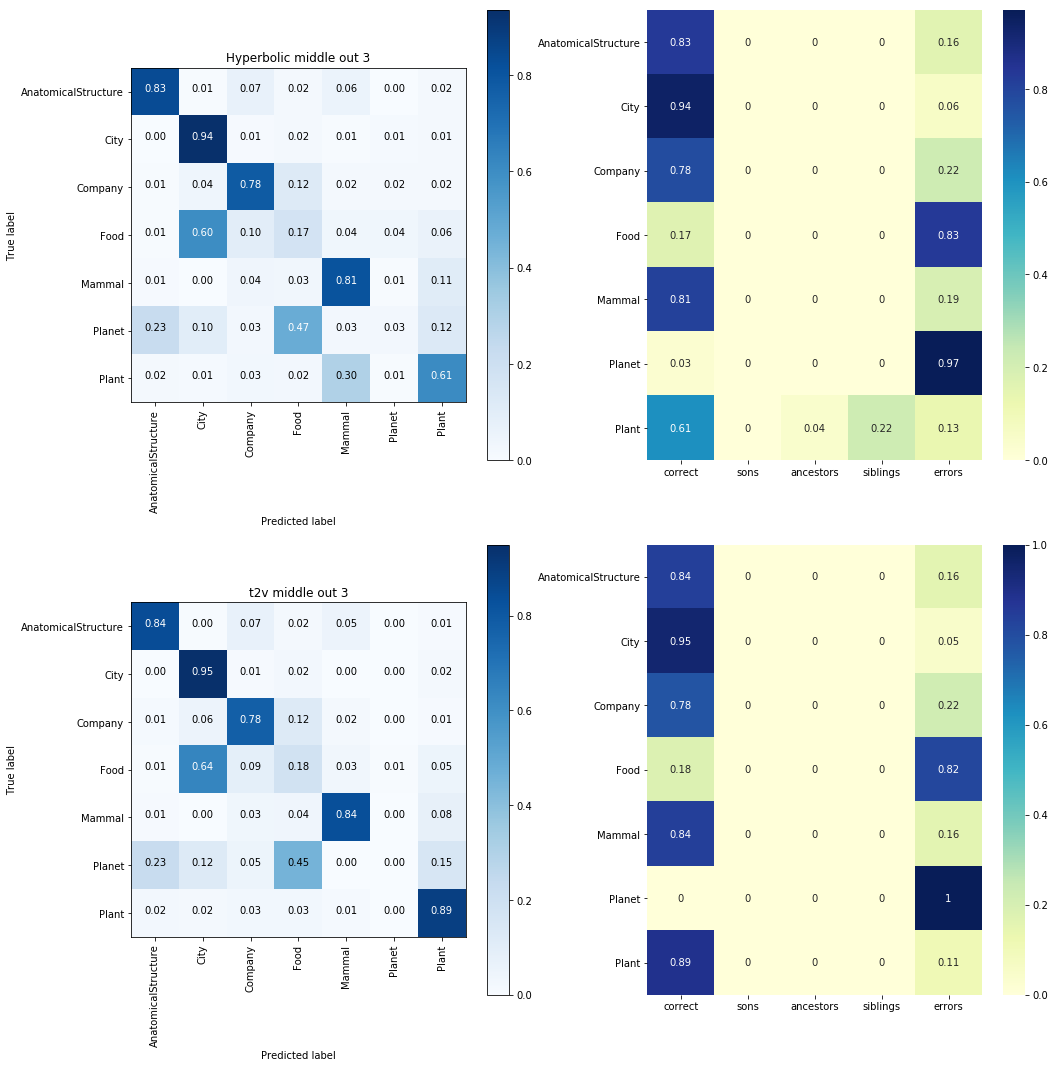

In [136]:
double_plot(tri_mo_mixed_model, tri_encoded_test, 3, len(X_test), classes, parenthood)
plt.savefig('./im/triple_performance.png')

## PLOT

In [137]:
def pca_plot(X_train, X_test, train_colors, test_colors, sub1, sub2, title1, title2):
        sklearn_pca = PCA(n_components=2)
        
        sklearn_pca.fit(np.concatenate((X_train, X_test), axis = 0))

        data = sklearn_pca.transform(X_train)
        X_plot = [x[0] for x in data]
        Y_plot = [x[1] for x in data]
        
        data_test = sklearn_pca.transform(X_test)
        X_test_plot = [x[0] for x in data_test]
        Y_test_plot = [x[1] for x in data_test]
        
        X_min = min(np.append(X_plot, X_test_plot))
        X_max = max(np.append(X_plot, X_test_plot))
        Y_min = min(np.append(Y_plot, Y_test_plot))
        Y_max = max(np.append(Y_plot, Y_test_plot))
        
        plt.subplot(sub1)
        plt.scatter(X_plot, Y_plot, c = train_colors)
        plt.title(title1)
        
        plt.xlim(X_min - 1, X_max + 1)
        plt.ylim(Y_min - 1, Y_max + 1)

        
        plt.subplot(sub2)
        plt.scatter(X_test_plot, Y_test_plot, c = test_colors)
        plt.title(title2)
        
        plt.xlim(X_min - 1, X_max + 1)
        plt.ylim(Y_min - 1, Y_max + 1)

In [83]:
colors = ['b', 'g', 'r', 'c', 'm', '#d3d3d3', 'k', '#964b00', '#ffa500', 'tab:orange', 'tab:pink']
color_map = {cla: col for cla,col in zip(classes, colors)}
verbose_color = ['Blue', 'Green', 'Red', 'Cyan', 'Magenta', 'Grey', 'Black', 'Brown', 'Orange', 'Pink']
verbose_color_map = {x: y for x,y in zip(color_map.keys(), verbose_color)}

In [139]:
def xcluded_plot(exclude, 
           X_train, 
           Y_train, 
           encoded_train, 
           double_encoded_train, 
           tri_encoded_train, 
           X_test,
           Y_test,
           encoded_test,
           double_encoded_test,
           tri_encoded_test,
           patchList, 
           color_map):
    excluded_classes = [k for k in classes if k not in exclude]
    
    train_colors = [color_map[k] for k in Y_train if k not in exclude]
    test_colors = [color_map[k] for k in Y_test if k not in exclude]
    
    Xcluded_train = np.array([k for k,l in zip(X_train, Y_train) if l not in exclude])
    Xcluded_test = np.array([k for k,l in zip(X_test, Y_test) if l not in exclude])
    
    Xcluded_encoded_train = np.array([k for k, l in zip(encoded_train, Y_train) if l not in exclude])
    Xcluded_encoded_test = np.array([k for k, l in zip(encoded_test, Y_test) if l not in exclude])
    
    Xcluded_double_encoded_train = np.array([k for k, l in zip(double_encoded_train, Y_train) if l not in exclude])
    Xcluded_double_encoded_test = np.array([k for k, l in zip(double_encoded_test, Y_test) if l not in exclude])
    
    Xcluded_triple_encoded_train = np.array([k for k, l in zip(tri_encoded_train, Y_train) if l not in exclude])
    Xcluded_triple_encoded_test = np.array([k for k, l in zip(tri_encoded_test, Y_test) if l not in exclude])
    
    Ycluded_train = np.array([l for l in Y_train if l not in exclude])
    Ycluded_test = np.array([l for l in Y_test if l not in exclude])
    
    plt.figure(figsize=(20, 10))
                    
    pca_plot(X_train=Xcluded_train, 
             X_test=Xcluded_test, 
             train_colors=train_colors, 
             test_colors=test_colors,
             sub1 = 241, 
             sub2 = 245, 
             title1='Original Train Data', 
             title2='Original Test Data')

    pca_plot(X_train=Xcluded_encoded_train, 
             X_test=Xcluded_encoded_test, 
             train_colors=train_colors,
             test_colors=test_colors,
             sub1 = 242, 
             sub2 = 246, 
             title1='Middle-Out Train Data', 
             title2='Middle-Out Test Data')
    
    pca_plot(X_train=Xcluded_double_encoded_train, 
             X_test=Xcluded_double_encoded_test, 
             train_colors=train_colors,
             test_colors=test_colors,
             sub1 = 243, 
             sub2 = 247, 
             title1='Double Middle-Out Train Data', 
             title2='Double Middle-Out Test Data')
    
    pca_plot(X_train=Xcluded_triple_encoded_train, 
             X_test=Xcluded_triple_encoded_test, 
             train_colors=train_colors, 
             test_colors=test_colors,
             sub1 = 244, 
             sub2 = 248, 
             title1='Triple Middle-Out Train Data', 
             title2='Triple Middle-Out Test Data')
    
    plt.legend(handles=patchList, bbox_to_anchor=(1.2, 1.4))
    plt.savefig('./im/pca_plots.png')

In [84]:
exclude = [
#     'Company'
#             ,'City'
#            , 'Plant'
#            , 'AnatomicalStructure'
#            , 'Mammal'
#            , 'Planet'
#             ,'Food'
#     , 'Software'
]

In [85]:
patchList = []
for key in verbose_color_map.keys():
    if key not in exclude:
        data_key = mpatches.Patch(color=verbose_color_map[key], label=key)
        patchList.append(data_key)

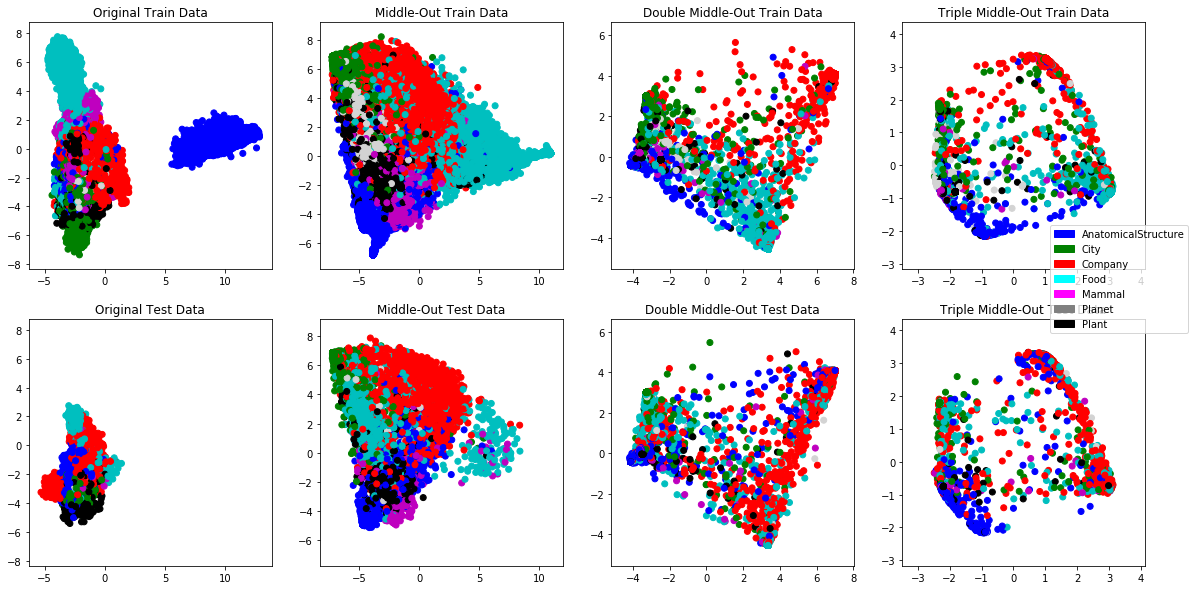

In [144]:
xcluded_plot(exclude=exclude, 
             X_train=X_train,
             Y_train=Y_train,
             encoded_train=encoded_train,
             double_encoded_train=double_encoded_train,
             tri_encoded_train=tri_encoded_train, 
             X_test=X_test,
             Y_test=Y_test,
             encoded_test=encoded_test,
             double_encoded_test=double_encoded_test,
             tri_encoded_test=tri_encoded_test,
             patchList=patchList,
             color_map=color_map)

In [456]:
 [[len(X_train), len(encoded_train), len(double_encoded_train), len(tri_encoded_train)],
 [len(X_test), len(encoded_test), len(double_encoded_test), len(tri_encoded_test)]]

NameError: name 'encoded_train' is not defined

In [274]:
classes = list(set(Y_train))
colors = ['#8bc34a', '#ffc107', '#795548',
          '#e91e63', '#259b24', '#cddc39',
          '#ff9800', '#e51c23', '#9c27b0',
          '#ffeb3b', '#03a9f4', '#607d8b',
          '#673ab7', '#009688', '#212121',
          '#ffff00', '#A52A2A']
color_map = {cla: col for cla, col in zip(classes, colors)}

verbose_color = ['Light Green', 'Amber', 'Deep Orange',
                 'Pink', 'Green', 'Lime',
                 'Orange', 'Red', 'Purple',
                 'Indigo', 'Light Blue', 'Blue Grey',
                 'Deep Purple', 'Teal', 'Text Black',
                 'Yellow', 'Brown']
patchList = []

for key in color_map.keys():
    data_key = mpatches.Patch(color=color_map[key], label=key)
    patchList.append(data_key)
# plt.legend(handles=patchList, bbox_to_anchor=(1, 1.5))

1.0


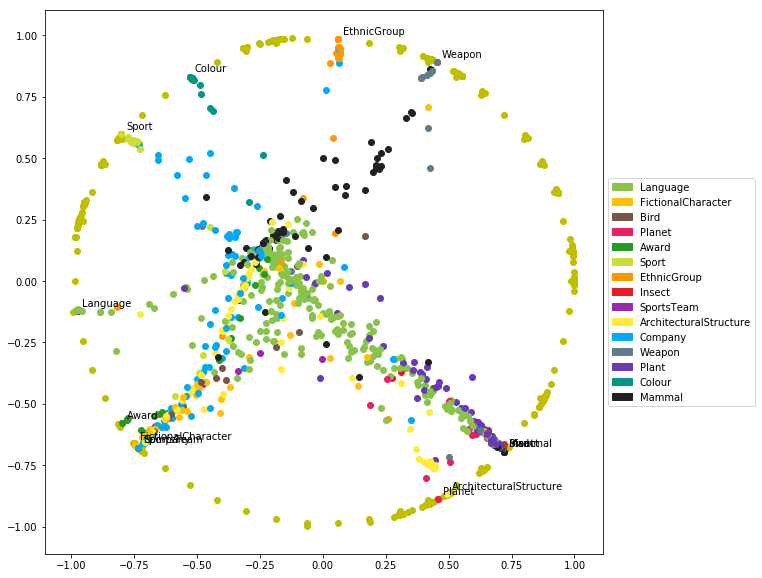

In [275]:
plt.figure(figsize=(10,10))

for l, p in hyperbolic_embedding.items():
    plt.scatter(p[0], p[1], c = 'y')
    if l in classes:
        plt.scatter(p[0], p[1], c = 'r')
        plt.text(p[0] + 0.02, p[1] + 0.02, l)

class_plot = [hyperbolic_embedding[c] for c in classes]
        
for i, c in enumerate(class_plot):
    plt.scatter(c[0], c[1], color = color_map[classes[i]])
# plt.xlim(min(X_plot) - 0.1 , max(X_plot) + 0.1)
# plt.ylim(min(Y_plot) - 0.1 , max(Y_plot) + 0.1)

# plt.xlim(min(X_plot) - 0.1 , max(X_plot) + 0.1)
# plt.ylim(min(Y_plot) - 0.1 , max(Y_plot) + 0.1)

plt.legend(handles=patchList, bbox_to_anchor=(1, 0.7))

n = 1000

pred = mixed_model.predict(X_test[:n])[1]
# pred = mo_mixed_model.predict(encoded_test[:n])[1]
# pred = regr.predict(X_test[:n])

mms = 0
fhs = 0
min_p = 0
for i, c in enumerate(pred):
    plt.scatter(c[0], c[1], color = color_map[Y_test[i]])
    
    div = round(i/n , 2)
    
    if div != min_p:
        min_p = div
        clear_output()
        print('{}'.format(min_p))
        
plt.savefig('./im/full/hypred')

In [237]:
pred = mixed_model.predict(X_test)[1]

modes = ['rfr', 'single', 'double']
centroids = {m:{c:[]} for m in modes for c in classes}

pred_dict = {c:[] for c in classes}
for i, p in enumerate(pred):
#     if norm(p) < 1:
        pred_dict[Y_test[i]].append(p)

for c in classes:
    centroids['double'][c] = midpoint(pred_dict[c])
    

pred = single_hyp_model.predict(X_test)
pred_dict = {c:[] for c in classes}
for i, p in enumerate(pred):
#     if norm(p) < 1:
        pred_dict[Y_test[i]].append(p)

for c in classes:
    centroids['single'][c] = midpoint(pred_dict[c])
    
pred = hyp_regr.predict(X_test)
pred_dict = {c:[] for c in classes}
for i, p in enumerate(pred):
#     if norm(p) < 1:
        pred_dict[Y_test[i]].append(p)

for c in classes:
    centroids['rfr'][c] = midpoint(pred_dict[c])


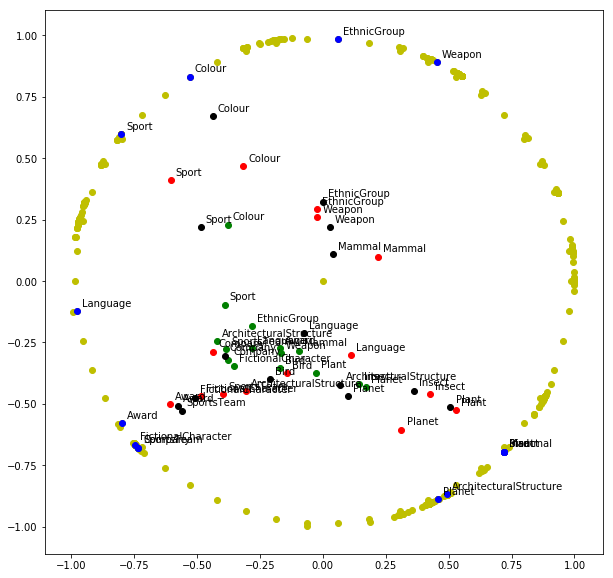

In [238]:
plt.figure(figsize=(10,10))

for l, p in zip(hyperbolic_embedding.keys(), hyperbolic_embedding.values()):
    plt.scatter(p[0], p[1], c = 'y')
    if l in classes:
#         plt.scatter(p[0], p[1], c = color_map[l])
        plt.text(p[0] + 0.02, p[1] + 0.02, l)

class_plot = [hyperbolic_embedding[c] for c in classes]
        
for i, c in enumerate(class_plot):
    plt.scatter(c[0], c[1], color = 'b')

for k,v in zip(centroids['double'].keys(), centroids['double'].values()):
    if not np.isnan(v[0]):
        plt.scatter(v[0], v[1], color = 'r')
        plt.text(v[0] + 0.02, v[1] + 0.02, k)


for k,v in zip(centroids['rfr'].keys(), centroids['rfr'].values()):
    if not np.isnan(v[0]):
        plt.scatter(v[0], v[1], color = 'g')
        plt.text(v[0] + 0.02, v[1] + 0.02, k)
        

for k,v in zip(centroids['single'].keys(), centroids['single'].values()):
    if not np.isnan(v[0]):
        plt.scatter(v[0], v[1], color = 'k')
        plt.text(v[0] + 0.02, v[1] + 0.02, k)
        
plt.savefig('./im/full/test_centroids')

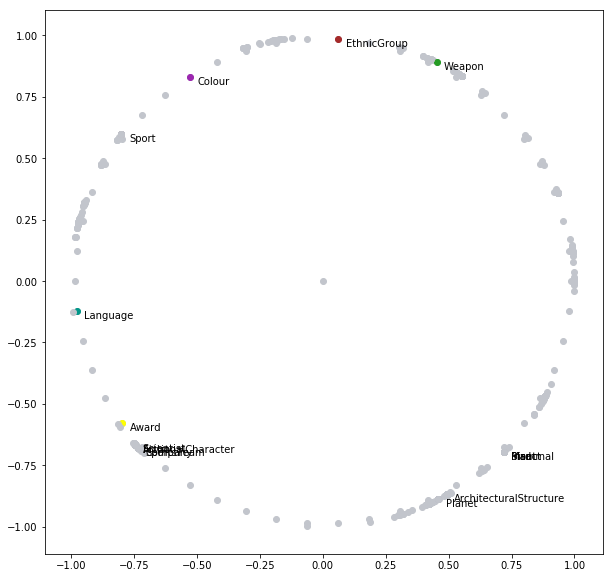

In [840]:
plt.figure(figsize=(10,10))

for l, p in zip(hyperbolic_embedding.keys(), hyperbolic_embedding.values()):
    plt.scatter(p[0], p[1], c = '#C2C5CC')
    if l in classes:
        plt.scatter(p[0], p[1], c = color_map[l])
        plt.text(p[0] + 0.03, p[1] - 0.03, l)

plt.savefig('./im/full/hyper_types')


## Random Forest Regressor

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [58]:
save_data_with_pickle('/datahdd/vmanuel/datasets/models/random_regr', regr)

In [275]:
hyper_distance(centroids['Weapon'], hyperbolic_embedding['Weapon'], r=1)

8.898125524879623

In [ ]:
for k, v in class_dists.items():
    print('mean hyper distance for {}: {}'.format(k, round(np.mean(v), 4)))

for k, v in centroids.items():
    print('centroid hyper distance for {}: {}'.format(k, round(hyper_distance(v, 
                                                                              hyperbolic_embedding[k], 
                                                                              1)
                                                               , 4)))

In [131]:
centroids

{'Bird': array([ 0.41172948, -0.56198789]),
 'Company': array([-0.59394376, -0.57073134]),
 'Insect': array([ 0.08696694, -0.3762542 ]),
 'Weapon': array([ 0.26788102, -0.4154389 ]),
 'FictionalCharacter': array([-0.08715787, -0.34501026]),
 'Sport': array([-0.48906079, -0.10701799]),
 'Planet': array([ 0.57438503, -0.72544103]),
 'Colour': array([-0.4889797 ,  0.64618422]),
 'Plant': array([ 0.59866584, -0.61264211]),
 'ArchitecturalStructure': array([-0.29824171, -0.43691958]),
 'SportsTeam': array([-0.30350829, -0.28209496]),
 'Mammal': array([ 0.23531244, -0.42948191]),
 'Language': array([-0.30131914, -0.1485689 ]),
 'Award': array([-0.47296731, -0.48781438]),
 'EthnicGroup': array([-0.27060272,  0.11131841])}

In [49]:
preds = regr.predict(X_test)

class_dists = {c:[] for c in classes}
class_points = {c:[] for c in classes}

for i, p in enumerate(preds):
    d = hyper_distance(p, hyperbolic_embedding[Y_test[i]], r=1)
    class_dists[Y_test[i]].append(d)
    class_points[Y_test[i]].append(p)
    
    
    
    
centroids = {}
for c in classes:
    centroids[c] = midpoint(class_points[c])
#     euclids[c] = np.sum(np.array(class_points[c])/len(class_points[c]), axis=0)



### Random Forest

In [36]:
t = time.time()
dis_regr = RandomForestRegressor(max_depth=8, 
                                 random_state=0,
                                 n_estimators=15,
                                 n_jobs = 5)
dis_regr.fit(X_train[:10000], y_t2v_train[:10000])
time.time()-t

56.2984299659729

In [37]:
t = time.time()
hyp_regr = RandomForestRegressor(max_depth=8, 
                                 random_state=0,
#                                  criterion=hyperbolic_loss,
                                 n_estimators=15,
                                 n_jobs = 5)
hyp_regr.fit(X_train[:10000], y_hyp_train[:10000])
time.time()-t

14.679264068603516

### Simple Network

In [38]:

inp = Input(shape=(1024, ))

mixed = Dense(256, activation = "tanh")(inp)
droppy = Dropout(0.3)(mixed)
mixed = Dense(128, activation = "tanh")(droppy)
droppy = Dropout(0.3)(mixed)
mixed = Dense(128, activation = "tanh")(droppy)
droppy = Dropout(0.3)(mixed)
mixed = Dense(64, activation = "tanh")(droppy)

hyperbolic_embedding_layer = Dense(2, name='Hyper')(mixed)
dis_embedding_layer = Dense(100, name='Hyper')(mixed)


early_stop = EarlyStopping(monitor='val_loss', patience = 20, restore_best_weights=True)



single_hyp_model = Model(input=inp, output=hyperbolic_embedding_layer)


single_hyp_model.compile(optimizer='adam', loss=hyperbolic_loss)

single_hyp_history = single_hyp_model.fit(X_train
                                , y_hyp_train 
                                , epochs = 200
                                , batch_size = 512
                                , validation_data=(X_val, y_hyp_val)
                                , shuffle = True
                                , callbacks = [early_stop]
               )


/home/vmanuel/venv/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("Hy...)`


Train on 130136 samples, validate on 13065 samples
Epoch 1/200
130136/130136 [==============================] - 4s 31us/step - loss: 43.1155 - val_loss: 40.1964
Epoch 2/200
130136/130136 [==============================] - 3s 23us/step - loss: 40.1152 - val_loss: 39.9981
Epoch 3/200
130136/130136 [==============================] - 3s 24us/step - loss: 39.6872 - val_loss: 39.8725
Epoch 4/200
130136/130136 [==============================] - 3s 23us/step - loss: 39.3548 - val_loss: 39.0191
Epoch 5/200
130136/130136 [==============================] - 3s 23us/step - loss: 39.0814 - val_loss: 39.8270
Epoch 6/200
130136/130136 [==============================] - 3s 24us/step - loss: 38.6987 - val_loss: 37.0016
Epoch 7/200
130136/130136 [==============================] - 3s 23us/step - loss: 38.2591 - val_loss: 37.6308
Epoch 8/200
130136/130136 [==============================] - 3s 24us/step - loss: 38.1228 - val_loss: 39.8531
Epoch 9/200
130136/130136 [==============================] - 3s 24us/

In [39]:
inp = Input(shape=(1024, ))

mixed = Dense(256, activation = "tanh")(inp)
droppy = Dropout(0.3)(mixed)
mixed = Dense(128, activation = "tanh")(droppy)
droppy = Dropout(0.3)(mixed)
mixed = Dense(128, activation = "tanh")(droppy)
droppy = Dropout(0.3)(mixed)
mixed = Dense(128, activation = "tanh")(droppy)

hyperbolic_embedding_layer = Dense(2, name='Hyper')(mixed)
dis_embedding_layer = Dense(100, name='Hyper')(mixed)


early_stop = EarlyStopping(monitor='val_loss', patience = 20, restore_best_weights=True)



single_dis_model = Model(input=inp, output=dis_embedding_layer)
single_dis_model.compile(optimizer='adam', loss=cosine_loss)
single_dis_history = single_dis_model.fit(X_train
                                , y_t2v_train
                                , epochs = 200
                                , batch_size = 1024
                                , validation_data=(X_val, y_t2v_val)
                                , shuffle = True
                                , callbacks = [early_stop])

/home/vmanuel/venv/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("Hy...)`


Train on 130136 samples, validate on 13065 samples
Epoch 1/200
130136/130136 [==============================] - 3s 22us/step - loss: -7.6326 - val_loss: -7.7502
Epoch 2/200
130136/130136 [==============================] - 2s 18us/step - loss: -9.1614 - val_loss: -8.2907
Epoch 3/200
130136/130136 [==============================] - 2s 18us/step - loss: -9.4160 - val_loss: -8.3663
Epoch 4/200
130136/130136 [==============================] - 2s 17us/step - loss: -9.5136 - val_loss: -8.3692
Epoch 5/200
130136/130136 [==============================] - 2s 17us/step - loss: -9.5768 - val_loss: -8.3448
Epoch 6/200
130136/130136 [==============================] - 2s 18us/step - loss: -9.6193 - val_loss: -8.3239
Epoch 7/200
130136/130136 [==============================] - 2s 18us/step - loss: -9.6491 - val_loss: -8.4059
Epoch 8/200
130136/130136 [==============================] - 2s 18us/step - loss: -9.6688 - val_loss: -8.3650
Epoch 9/200
130136/130136 [==============================] - 2s 18us/

In [141]:
unique = {c: [] for c in classes}
pat = re.compile('[a-z]*')
for i, w in enumerate(word_train):
    w = re.findall(pat, w)[0]
    if w not in unique[Y_train[i]]:
        unique[Y_train[i]].append(w)

In [143]:
unique = {k:len(v) for k,v in unique.items()}

In [396]:
unique

{'Bird': 203,
 'Company': 1563,
 'Insect': 189,
 'Weapon': 201,
 'FictionalCharacter': 1127,
 'Sport': 198,
 'Planet': 64,
 'Colour': 47,
 'Plant': 901,
 'ArchitecturalStructure': 480,
 'SportsTeam': 129,
 'Mammal': 331,
 'Language': 385,
 'Award': 113,
 'EthnicGroup': 556}

In [147]:
for k,v in unique.items():
    print('{} {} {}'.format(k, v, Counter(Y_train)[k]))

Bird 203 1435
Company 1563 36647
Insect 189 953
Weapon 201 2043
FictionalCharacter 1127 8026
Sport 198 4459
Planet 64 2140
Colour 47 6938
Plant 901 13645
ArchitecturalStructure 480 5077
SportsTeam 129 828
Mammal 331 9510
Language 385 20566
Award 113 2335
EthnicGroup 556 6411


In [195]:
from sklearn.metrics import mean_squared_error

def distances(Y_test, rfr_pred,  single_pred, double_pred, mode, measure):
    models = ['rfr', 'single', 'double']
    cs = set(Y_test)
    
    class_dists = {r: {} for r in models}
    class_dists['rfr'] = {c:[] for c in cs}
    class_dists['single'] = {c:[] for c in cs}
    class_dists['double'] = {c:[] for c in cs}
    
    class_points = {r: {} for r in models}
    class_points['rfr'] = {c:[] for c in cs}
    class_points['single'] = {c:[] for c in cs}
    class_points['double'] = {c:[] for c in cs}
    
    returns = {r: {} for r in models}
    returns['rfr'] = {c:[] for c in cs}
    returns['single'] = {c:[] for c in cs}
    returns['double'] = {c:[] for c in cs}
    returns['tot'] = {m: [] for m in models}
    
    for model, preds in zip(models,[rfr_pred, single_pred, double_pred]):
        for i, p in enumerate(preds):
            if measure != 'centroid':
                if mode == 'hyper' and norm(p) < 1:
                    d = hyper_distance(p, hyperbolic_embedding[Y_test[i]], r=1)
#                     d = mean_squared_error(p, hyperbolic_embedding[Y_test[i]])
                    
                    class_dists[model][Y_test[i]].append(d)
                    returns['tot'][model].append(d)
                    
                elif mode != 'hyper':
                    d = cos_sim(p, type_embedding[Y_test[i]])
#                     d = mean_squared_error(p, type_embedding[Y_test[i]])
                    
                    class_dists[model][Y_test[i]].append(d)
                    
                    returns['tot'][model].append(d)
                    
                    
            elif mode == 'hyper' and norm(p) < 1:
                class_points[model][Y_test[i]].append(p)   
            elif mode != 'hyper': 
                class_points[model][Y_test[i]].append(p)   
                
    for m in models:
        for c in cs:
            if mode == 'hyper' and measure == 'centroid':
                returns[m][c] = hyper_distance(midpoint(class_points[m][c]), hyperbolic_embedding[c], r=1)
#                 returns[m][c] = mean_squared_error(sum(class_points[m][c])/len(class_points[m][c]), 
#                                                    hyperbolic_embedding[c])
                returns['tot'][m].append(returns[m][c]) 
                
            elif mode != 'hyper' and measure == 'centroid':
                returns[m][c] = cos_sim(sum(class_points[m][c])/len(class_points[m][c]), type_embedding[c])
#                 returns[m][c] = mean_squared_error(sum(class_points[m][c])/len(class_points[m][c]), 
#                                                    type_embedding[c])
                
                returns['tot'][m].append(returns[m][c]) 
            else:
                returns[m][c] = np.mean(class_dists[m][c])
                returns['tot'][m].append(returns[m][c]) 
                    
    
    for k, v in returns['tot'].items():
        returns['tot'][k] = np.mean(v)
        
    return returns

def print_res(X_test, Y_test, double, single, rfr, mode, measure, t = 'no'):
    single_pred = single.predict(X_test)
    rfr_pred = rfr.predict(X_test)
    
    if mode == 'hyper':
        try:
            title = 'Hyperbolic '
            double_pred = double.predict(X_test)[1]
        except:
            double_pred = double.predict(encoded_test)[1]
    else:
        try:
            title = 'Rank of Distributional '
            double_pred = double.predict(X_test)[0]
        except:
            double_pred = double.predict(encoded_test)[0]
    
            
    
    if measure == 'centroid':
        title += 'centroid predictions'
    elif measure == 'mean':
        title += 'mean distance'
    
    print('-----------------------------------------------------------------------------------------------------------')
    print('{:^105}'.format(title))
    print('-----------------------------------------------------------------------------------------------------------')    
    print('{:^33}|{:^24}|{:^24}|{:^24}'.format('Class', 'RFR', 'Single', 'Double'))
    print('{:-^33}|{:-^24}|{:-^24}|{:-^24}'.format('', '', '', ''))
    if t != 'quantile':
        ret_dic = distances(Y_test, rfr_pred, single_pred, double_pred, mode, measure)
    else:
        ret_dic = quantiles(Y_test, rfr_pred, single_pred, double_pred, mode, measure)
    for c in ret_dic['rfr'].keys():
        print('{:^33}|{:^24.4f}|{:^24.4f}|{:^24.4f}'.format(c, ret_dic['rfr'][c], ret_dic['single'][c], ret_dic['double'][c])) 
    print('-----------------------------------------------------------------------------------------------------------')
    print('{:^33}|{:^24.4f}|{:^24.4f}|{:^24.4f}'.format('global {} distance : '.format(measure), 
                                                        ret_dic['tot']['rfr'],
                                                        ret_dic['tot']['single'],
                                                        ret_dic['tot']['double']
                                                       ))

def quantiles(Y_test, rfr_pred, single_pred, double_pred, mode, measure):
    models = ['rfr', 'single', 'double']
    cs = list(set(Y_test))
    
    class_dists = {r: {} for r in models}
    class_dists['rfr'] = {c:[] for c in cs}
    class_dists['single'] = {c:[] for c in cs}
    class_dists['double'] = {c:[] for c in cs}
    
    class_points = {r: {} for r in models}
    class_points['rfr'] = {c:[] for c in cs}
    class_points['single'] = {c:[] for c in cs}
    class_points['double'] = {c:[] for c in cs}
    
    returns = {r: {} for r in models}
    returns['rfr'] = {c:[] for c in cs}
    returns['single'] = {c:[] for c in cs}
    returns['double'] = {c:[] for c in cs}
    returns['tot'] = {m: [] for m in models}

    tensors = np.array([v for v in hyperbolic_embedding.values()])
    
#     print(cs)
    if mode == 'hyper':
        parenthood = get_parenthood(cs)
    
    for model, preds in zip(models,[rfr_pred, single_pred, double_pred]):
        for i, p in enumerate(preds):
            if measure == 'mean' and mode == 'cosine':
                dists, rank = find_neighbours(mode='t2v',
                                              model=type_embedding,
                                              vector=p,
                                              tensors=0,
                                              topn = 403)
                
                d = rank.index(Y_test[i]) + 1
                
                class_dists[model][Y_test[i]].append(d)
                returns['tot'][model].append(d)
            elif measure == 'mean' and mode == 'hyper':
                
                anc = [Y_test[i]] + parenthood[Y_test[i]]['ancestors']
                min_rank = len(tensors)
                dists, rank = find_neighbours(mode='hyper',
                                          model=hyperbolic_embedding,
                                          vector=p,
                                          tensors=tensors,
                                          topn = len(tensors))
                for a in anc:
                    try:
                        if rank.index(a) + 1 < min_rank:
                            min_rank = rank.index(a) + 1
                    except:
                        pass
                        
                class_dists[model][Y_test[i]].append(min_rank)
                returns['tot'][model].append(min_rank)
            elif measure == 'centroid':
                class_points[model][Y_test[i]].append(p)
            
    for m in models:
        for c in cs:
            if measure != 'centroid':
                returns[m][c] = np.mean(class_dists[m][c])
                returns['tot'][m].append(returns[m][c]) 
            elif mode == 'cosine':
                centroid = sum(class_points[m][c])/len(class_points[m][c])
                
                dists, rank = find_neighbours(mode='t2v',
                                              model=type_embedding,
                                              vector=centroid,
                                              tensors=0,
                                              topn = 403)
                
                returns[m][c] = rank.index(c) + 1
                returns['tot'][m].append(returns[m][c])
            else:
                centroid = midpoint(class_points[m][c])
                dists, rank = find_neighbours(mode='hyper',
                                              model=hyperbolic_embedding,
                                              vector=centroid,
                                              tensors=tensors,
                                              topn = len(tensors))
                returns[m][c] = rank.index(c) + 1
                returns['tot'][m].append(returns[m][c])
                
    for k, v in returns['tot'].items():
        returns['tot'][k] = np.mean(v)
    
    return returns

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [196]:
print_res(X_test, Y_test, mixed_model, single_dis_model, dis_regr, 'cosine', 'mean', 'quantile')

-----------------------------------------------------------------------------------------------------------
                                  Rank of Distributional mean distance                                   
-----------------------------------------------------------------------------------------------------------
              Class              |          RFR           |         Single         |         Double         
---------------------------------|------------------------|------------------------|------------------------
            Language             |        164.0439        |        146.8093        |        206.7229        
       FictionalCharacter        |        19.4026         |        16.6803         |        19.7500         
              Bird               |        81.0538         |        136.8638        |        128.6380        
             Planet              |        99.4068         |        30.0593         |        45.4110         
              Award     

In [197]:
print_res(X_test, Y_test, mixed_model, single_dis_model, dis_regr, 'cosine', 'centroid', 'quantile')

-----------------------------------------------------------------------------------------------------------
                               Rank of Distributional centroid predictions                               
-----------------------------------------------------------------------------------------------------------
              Class              |          RFR           |         Single         |         Double         
---------------------------------|------------------------|------------------------|------------------------
            Language             |         4.0000         |         6.0000         |        33.0000         
       FictionalCharacter        |         2.0000         |         1.0000         |         1.0000         
              Bird               |        36.0000         |        28.0000         |         2.0000         
             Planet              |        88.0000         |         1.0000         |         1.0000         
              Award     

In [198]:
print_res(X_test[:1000], Y_test, mixed_model, single_hyp_model, hyp_regr, 'hyper', 'mean', 'quantile')

-----------------------------------------------------------------------------------------------------------
                                        Hyperbolic mean distance                                         
-----------------------------------------------------------------------------------------------------------
              Class              |          RFR           |         Single         |         Double         
---------------------------------|------------------------|------------------------|------------------------
norm: 1.036024808883667
norm: 1.0069173574447632
norm: 1.015419840812683
            Language             |        15.0361         |        26.5740         |        35.7581         
       FictionalCharacter        |         7.0926         |         6.6296         |         5.4074         
              Bird               |        21.8710         |        30.6774         |        22.1935         
             Planet              |         6.8000         | 

In [199]:
print_res(X_test, Y_test, mixed_model, single_hyp_model, hyp_regr, 'hyper', 'centroid', 'quantile')

-----------------------------------------------------------------------------------------------------------
                                     Hyperbolic centroid predictions                                     
-----------------------------------------------------------------------------------------------------------
              Class              |          RFR           |         Single         |         Double         
---------------------------------|------------------------|------------------------|------------------------
            Language             |        12.0000         |        19.0000         |        30.0000         
       FictionalCharacter        |        273.0000        |        250.0000        |        255.0000        
              Bird               |        647.0000        |        651.0000        |        646.0000        
             Planet              |        240.0000        |        242.0000        |        201.0000        
              Award     

In [200]:
tensors = [v for v in hyperbolic_embedding.values()]
dist, rank = find_neighbours(vector=centroids['single']['Bird'],
                                 model=hyperbolic_embedding, 
                                 mode='hyper',
                                 topn=len(tensors),
                                 tensors=tensors)
rank.index('Bird')

650

In [188]:
centroids['single']['Planet']

array([ 0.0999514 , -0.46879667])

### Invention Evaluation

In [48]:
X_invention = load_data_with_pickle('/datahdd/vmanuel/datasets/invention_datasets/16_classes/X_invention_1')
Y_invention = load_data_with_pickle('/datahdd/vmanuel/datasets/invention_datasets/16_classes/Y_invention_1')

In [202]:
print_res(X_invention, Y_invention, mixed_model, single_dis_model, dis_regr, 'cosine', 'mean', 'quantile')

-----------------------------------------------------------------------------------------------------------
                                  Rank of Distributional mean distance                                   
-----------------------------------------------------------------------------------------------------------
              Class              |          RFR           |         Single         |         Double         
---------------------------------|------------------------|------------------------|------------------------
             Reptile             |        28.9807         |        24.1667         |        23.3816         
     EducationalInstitution      |        115.2245        |        157.7143        |        134.3469        
            Mollusca             |        128.9083        |        160.6833        |        144.4972        
        GovernmentAgency         |        299.4468        |        304.0445        |        337.3675        
            Currency    

In [203]:
print_res(X_invention, Y_invention, mixed_model, single_dis_model, dis_regr, 'cosine', 'centroid', 'quantile')

-----------------------------------------------------------------------------------------------------------
                               Rank of Distributional centroid predictions                               
-----------------------------------------------------------------------------------------------------------
              Class              |          RFR           |         Single         |         Double         
---------------------------------|------------------------|------------------------|------------------------
             Reptile             |         6.0000         |         3.0000         |         3.0000         
     EducationalInstitution      |        107.0000        |        148.0000        |        120.0000        
            Mollusca             |        95.0000         |        101.0000        |        86.0000         
        GovernmentAgency         |        300.0000        |        317.0000        |        358.0000        
            Currency    

In [207]:
print_res(X_invention[1000:2000], Y_invention, mixed_model, single_hyp_model, hyp_regr, 'hyper', 'mean', 'quantile')

-----------------------------------------------------------------------------------------------------------
                                        Hyperbolic mean distance                                         
-----------------------------------------------------------------------------------------------------------
              Class              |          RFR           |         Single         |         Double         
---------------------------------|------------------------|------------------------|------------------------
             Reptile             |        27.0000         |        31.5714         |        31.1071         
     EducationalInstitution      |         9.5000         |        40.5000         |        35.0000         
            Mollusca             |        25.2250         |        22.2375         |        18.8875         
        GovernmentAgency         |        10.0777         |        30.7985         |        25.2282         
            Currency    

In [206]:
print_res(X_invention, Y_invention, mixed_model, single_hyp_model, hyp_regr, 'hyper', 'centroid', 'quantile')

-----------------------------------------------------------------------------------------------------------
                                     Hyperbolic centroid predictions                                     
-----------------------------------------------------------------------------------------------------------
              Class              |          RFR           |         Single         |         Double         
---------------------------------|------------------------|------------------------|------------------------
             Reptile             |        403.0000        |        395.0000        |        389.0000        
     EducationalInstitution      |        246.0000        |        138.0000        |        194.0000        
            Mollusca             |        613.0000        |        585.0000        |        606.0000        
        GovernmentAgency         |        305.0000        |        371.0000        |        352.0000        
            Currency    

1.0


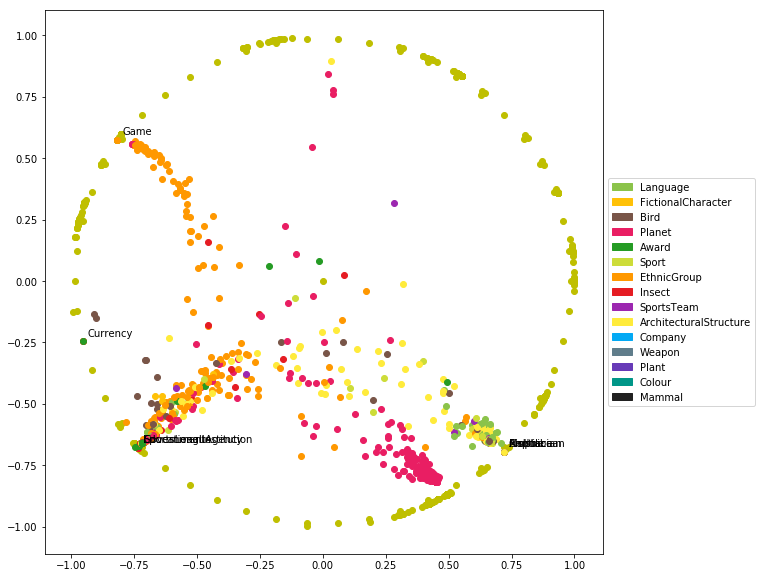

In [223]:


plt.figure(figsize=(10,10))

invention_classes = list(set(Y_invention))
color_map = {cla: col for cla, col in zip(invention_classes, colors)}

for l, p in hyperbolic_embedding.items():
    plt.scatter(p[0], p[1], c = 'y')
    if l in invention_classes:
        plt.scatter(p[0], p[1], c = 'r')
        plt.text(p[0] + 0.02, p[1] + 0.02, l)

class_plot = [hyperbolic_embedding[c] for c in invention_classes]
        
for i, c in enumerate(class_plot):
    plt.scatter(c[0], c[1], color = color_map[invention_classes[i]])
# plt.xlim(min(X_plot) - 0.1 , max(X_plot) + 0.1)
# plt.ylim(min(Y_plot) - 0.1 , max(Y_plot) + 0.1)

# plt.xlim(min(X_plot) - 0.1 , max(X_plot) + 0.1)
# plt.ylim(min(Y_plot) - 0.1 , max(Y_plot) + 0.1)

plt.legend(handles=patchList, bbox_to_anchor=(1, 0.7))

n = 1000

pred = mixed_model.predict(X_invention[:n])[1]
# pred = mo_mixed_model.predict(encoded_test[:n])[1]
# pred = regr.predict(X_test[:n])

mms = 0
fhs = 0
min_p = 0
for i, c in enumerate(pred):
    plt.scatter(c[0], c[1], color = color_map[Y_invention[i]])
    
    div = round(i/n , 2)
    
    if div != min_p:
        min_p = div
        clear_output()
        print('{}'.format(min_p))
        
plt.savefig('./im/full/hypred')

In [228]:
pred = mixed_model.predict(X_invention)[1]

modes = ['rfr', 'single', 'double']
centroids = {m:{c:[]} for m in modes for c in invention_classes}

pred_dict = {c:[] for c in invention_classes}
for i, p in enumerate(pred):
#     if norm(p) < 1:
        pred_dict[Y_invention[i]].append(p)

for c in invention_classes:
    centroids['double'][c] = midpoint(pred_dict[c])
    

pred = single_hyp_model.predict(X_invention)
pred_dict = {c:[] for c in invention_classes}
for i, p in enumerate(pred):
#     if norm(p) < 1:
        pred_dict[Y_invention[i]].append(p)

for c in invention_classes:
    centroids['single'][c] = midpoint(pred_dict[c])
    
pred = hyp_regr.predict(X_invention)
pred_dict = {c:[] for c in invention_classes}
for i, p in enumerate(pred):
#     if norm(p) < 1:
        pred_dict[Y_invention[i]].append(p)

for c in invention_classes:
    centroids['rfr'][c] = midpoint(pred_dict[c])


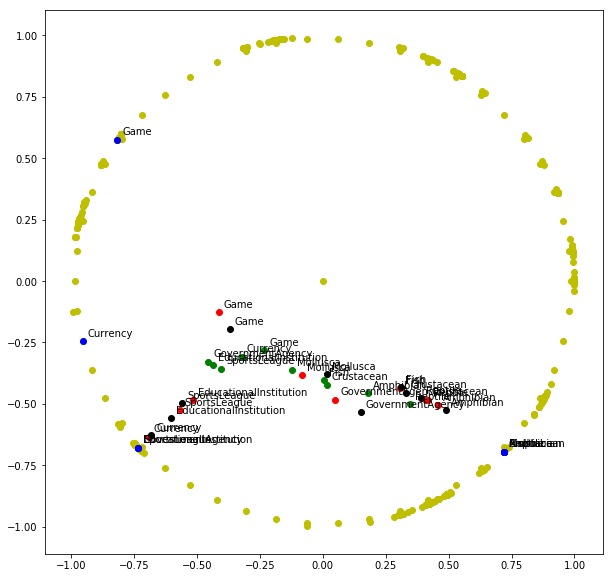

In [229]:
plt.figure(figsize=(10,10))

for l, p in zip(hyperbolic_embedding.keys(), hyperbolic_embedding.values()):
    plt.scatter(p[0], p[1], c = 'y')
    if l in invention_classes:
#         plt.scatter(p[0], p[1], c = color_map[l])
        plt.text(p[0] + 0.02, p[1] + 0.02, l)

class_plot = [hyperbolic_embedding[c] for c in invention_classes]
        
for i, c in enumerate(class_plot):
    plt.scatter(c[0], c[1], color = 'b')

for k,v in zip(centroids['double'].keys(), centroids['double'].values()):
    if not np.isnan(v[0]):
        plt.scatter(v[0], v[1], color = 'r')
        plt.text(v[0] + 0.02, v[1] + 0.02, k)


for k,v in zip(centroids['rfr'].keys(), centroids['rfr'].values()):
    if not np.isnan(v[0]):
        plt.scatter(v[0], v[1], color = 'g')
        plt.text(v[0] + 0.02, v[1] + 0.02, k)
        

for k,v in zip(centroids['single'].keys(), centroids['single'].values()):
    if not np.isnan(v[0]):
        plt.scatter(v[0], v[1], color = 'k')
        plt.text(v[0] + 0.02, v[1] + 0.02, k)
        
plt.savefig('./im/full/test_centroids')

## Quality Pred

In [261]:
quality_labels = load_data_with_pickle('/datahdd/vmanuel/datasets/invention_datasets/17_classes/quality_labels')
quality_vectors = load_data_with_pickle('/datahdd/vmanuel/datasets/invention_datasets/17_classes/quality_vectors')

In [262]:
hypred = mixed_model.predict(quality_vectors)[1]
dispred = mixed_model.predict(quality_vectors)[0]

In [263]:
occ = Counter(quality_labels)

In [264]:
occ

Counter({'alchemy': 17, 'beaver': 194, 'jpeg': 29, 'algae': 112})

In [211]:
quality_map = {'alcohol': 'g',
               'beaver': 'k',
               'jpeg': 'b'}

In [265]:
# m_beaver = midpoint(hypred[437:437+194])
# m_alcohol = midpoint(hypred[:437])
# m_jpeg = midpoint(hypred[437+194:437+194+29])
m_algae = midpoint(hypred[len(hypred)-113: len(hypred)])

(-1, 1)

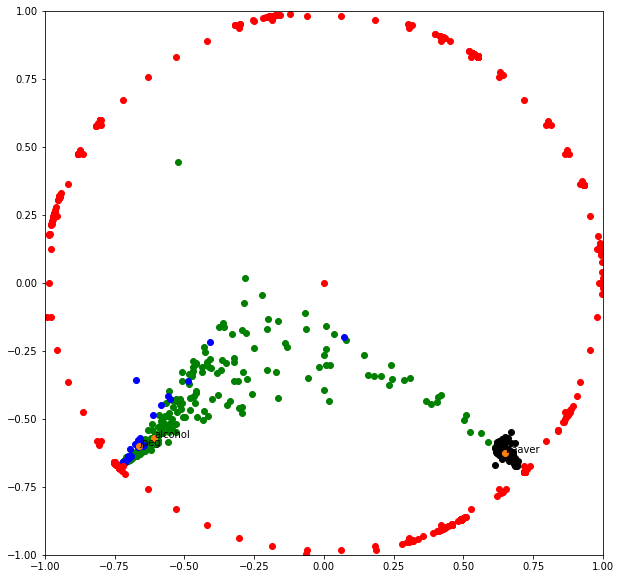

In [220]:
plt.figure(figsize=(10, 10))
for i, p in enumerate(hypred):
    plt.scatter(p[0], p[1], c = quality_map[quality_labels[i]])
    
for p in hyperbolic_embedding.values():
    plt.scatter(p[0], p[1], c = 'r')
    
plt.scatter(m_alcohol[0], m_alcohol[1], c='tab:orange')
plt.text(m_alcohol[0], m_alcohol[1], s='alcohol')

plt.scatter(m_beaver[0], m_beaver[1], c='tab:orange')
plt.text(m_beaver[0], m_beaver[1], s='beaver')

plt.scatter(m_jpeg[0], m_jpeg[1], c='tab:orange')
plt.text(m_jpeg[0], m_jpeg[1], s='jpeg')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

In [266]:
tensors = [v for v in hyperbolic_embedding.values()]
hyper_neigh = find_neighbours(vector=m_algae,
                                 model=hyperbolic_embedding, 
                                 mode='hyper',
                                 topn=10,
                                 tensors=tensors)


In [267]:
hyper_neigh

([2.3294790510776724,
  2.643599158992549,
  2.840225786501905,
  3.1081960207738484,
  3.4491991237823174,
  3.735163343499416,
  4.040908378544504,
  4.280739016388383,
  4.531876165052884,
  4.728308161557482],
 ['Thing',
  'Species',
  'ChemicalSubstance',
  'Polyhedron',
  'Unknown',
  'TopicalConcept',
  'Place',
  'RouteStop',
  'Biomolecule',
  'Depth'])

In [821]:
hyper_distance(m, hyperbolic_embedding['Mammal'])

15.683540828289171

In [268]:
# c_alcohol = sum(dispred[:437])/437
# c_beaver = sum(dispred[437:437+ 194])/194
# c_jpeg = sum(dispred[437+194:437+194+29])/29
c_algae = sum(dispred[len(hypred)-113: len(hypred)])/112

In [269]:
hyper_neigh = find_neighbours(vector=c_algae,
                                 model=type_embedding, 
                                 mode='t2v',
                                 topn=10,
                              tensors =0
                             )
hyper_neigh

([0.9994035959243774,
  0.6316008567810059,
  0.629362940788269,
  0.617064893245697,
  0.6126998662948608,
  0.5938873291015625,
  0.590526819229126,
  0.5645953416824341,
  0.5510637760162354,
  0.5443531274795532],
 ['Plant',
  'Conifer',
  'Fern',
  'Insect',
  'FloweringPlant',
  'Species',
  'Fungus',
  'Bird',
  'CultivatedVariety',
  'Cycad'])

## Quantiles analisys

In [873]:
quality_dic_vec = {l:np.array([v for i, v in enumerate(dispred) if quality_labels[i] == l]) for l in set(quality_labels)}

In [925]:
centroid = np.array(sum(quality_dic_vec['jpeg'])/occ['jpeg'])

tensors = np.array([v for v in hyperbolic_embedding.values()])

dists, rank = find_neighbours(mode='t2v',
                model=type_embedding,
                tensors=tensors,
                vector=centroid,
                topn = 403)

from scipy import stats

stats.percentileofscore(dists, cos_sim(centroid, type_embedding['Software']))/100*403

400.0

In [885]:
cos_sim(centroid, type_embedding['Software'])

0.61325383